# UNet
![](../img/unet.png)

In [137]:
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50

import multiprocessing

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

## Functions to better organize the pipeline
- `training_loop`: train the model
- `set_test`: test the model
- `load_unet_model`: load saved model checkpoints
- `test_predicted_image`: display image, predicted mask and ground truth mask
- `calculate_metrics`: calculate accuracy and IoU
- `update_average_loss`: update the average loss dictionary
- `calculate_f1_score`: calculate the F1 score

### UNet Architecture

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Downsample path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Upsample path
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, 
                                               feature, 
                                               kernel_size=2,
                                               stride=2))
            
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # Final layer - output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, x):
        
        # skip connections
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

### Calculate metrics

In [3]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)
    accuracy = (predicted_labels == true_labels).float().mean()
    return accuracy


def calculate_iou(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)

    intersection = torch.logical_and(predicted_labels, true_labels).sum().item()
    union = torch.logical_or(predicted_labels, true_labels).sum().item()

    iou = (intersection + 1e-5) / (union + 1e-5)
    
    return iou


def calculate_dice(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)

    intersection = (predicted_labels * true_labels).sum()
    union = predicted_labels.sum() + true_labels.sum()

    dice_score = (2 * intersection + 1e-5) / (union + 1e-5)

    return dice_score




def calculate_average_metrics(checkpoint: int, test_loader: DataLoader):
    
    print(f"Calculating IoU and accuracy for checkpoint {checkpoint}...")
    iou_scores = {}
    accuracy_scores = {}
    dice_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou_scores[i] = calculate_iou(outputs, masks)

        # Calculate accuracy
        accuracy_scores[i] = calculate_accuracy(outputs, masks)
        
        # Calculate dice
        dice_scores[i] = calculate_accuracy(outputs, masks)

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
    average_dice = sum(dice_scores.values()) / len(dice_scores)

    print(f"\nAverage IoU: {average_iou}")
    print(f"Average Accuracy: {average_accuracy}\n")
    print(f"Average Dice: {average_dice}\n")
    
    return iou_scores, accuracy_scores, dice_scores


### Save scores

In [38]:
import os
import json

def load_scores_from_json(filename: str) -> dict:
    """
    Load scores (loss, accuracy, IoU and dice score) from a JSON file.
    
    Args:
        filename (str): Path to the input JSON file.
    
    Returns:
        dict: Dictionary containing the loaded scores.
    """
    with open(filename, 'r') as file:
        scores = json.load(file)
    
    return scores

def save_scores_to_json(scores, output_file):
    """
    Save scores (loss, accuracy, IoU, dice score) to a JSON file.
    
    Args:
        scores (dict): Dictionary containing the new scores.
        output_file (str): Path to the output JSON file.
    """
    # Check if the file exists
    if not os.path.exists(output_file) or os.stat(output_file).st_size == 0:
        # If the file does not exist or is empty, save the scores directly
        with open(output_file, 'w') as file:
            json.dump(scores, file)
    else:
        # Load existing scores from the file
        with open(output_file, 'r') as file:
            existing_scores = json.load(file)
        
        # Append the new scores to the existing scores dictionary
        for key, value in scores.items():
            if key in existing_scores:
                existing_scores[key].update(value)
            else:
                existing_scores[key] = value
        
        # Save the updated scores back to the file
        with open(output_file, 'w') as file:
            json.dump(existing_scores, file)


### Training loop

In [5]:
def training_loop(model, checkpoint: int, num_epochs: int,
                  train_loader: DataLoader, criterion, optimizer: optim.Optimizer):
    """ Training loop. """
    
    accuracy = {}
    iou_score = {}
    dice_score = {}
    epoch_loss = {}
    
    #checkpoint = current_checkpoint
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Set the model to training mode
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        running_accuracy = 0.0
        running_iou = 0.0
        running_dice = 0.0

        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            images = images.to(device)
            masks = masks.to(device)
            
            # Expand masks along the channel dimension
            masks = masks.expand(-1, 3, -1, -1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            #loss = criterion(outputs, masks.squeeze(1).long())
            #loss = criterion(outputs, masks.unsqueeze(1).long())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, masks)
            running_iou += calculate_iou(outputs, masks)
            running_dice += calculate_dice(outputs, masks)
        
        epoch_loss[checkpoint + epoch] = running_loss / len(train_loader)
        accuracy[checkpoint + epoch] = running_accuracy / len(train_loader)
        iou_score[checkpoint + epoch] = running_iou / len(train_loader)
        dice_score[checkpoint + epoch] = running_dice / len(train_loader)
        
        print(f"Loss: {epoch_loss[checkpoint+epoch]:.14f} | Accuracy: {100*accuracy[checkpoint+epoch]:.14f}% | IoU: {iou_score[checkpoint+epoch]:.14f} | Dice: {dice_score[checkpoint+epoch]:.14f}\n")
        
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"../chk/model_{checkpoint+epoch}.pth")
            print(f"Model saved: ../chk/model_{checkpoint+epoch}.pth")
        
    print("Finished Training!")
    
    return epoch_loss, accuracy, iou_score, dice_score

# TODO: (by TG) create function to dump those scores to json file

### Load UNet model from a given checkpoint

In [6]:
def load_unet_model(in_channels: int, out_channels: int, current_checkpoint: int):
    """ Load a UNet model from a checkpoint """
    model = UNet(in_channels, out_channels)
    state_dict = model.state_dict()

    checkpoint = torch.load(f'../chk/model_{current_checkpoint}.pth')
    avoid = []
    for key in checkpoint.keys():
        if key in avoid or key not in state_dict.keys():
            continue
        if checkpoint[key].size() != state_dict[key].size():
            continue
        state_dict[key] = checkpoint[key]
    model.load_state_dict(state_dict)
    return model

### Update the average loss dictionary

In [7]:
def update_average_loss(avg_loss, average_loss):
    avg_loss.extend(average_loss)
    plt.plot(avg_loss)
    return avg_loss

### Set test

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

def set_test(model, current_checkpoint: int):
    """ Set test data and test loader then perform the test. """

    val_dir = "../data/pascal_voc_dataset/validation"
    test_dir = "../data/pascal_voc_dataset/test"

    # Transforms to input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Normalize tensor using mean and std
    def normalize_tensor(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

    # Transforms to target masks
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize_tensor,
    ])

    test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = Subset(test_set, range(1100))

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_cpu = multiprocessing.cpu_count()
    
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        print(f"Using {num_cpu} CPU cores.")
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
    else:
        print("Using single CPU.")

    model = model.to(device)

    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images)
            
        # Save each prediction as separate files using torch.save()
        torch.save(images.cpu(), f'../rsc/test/image_{i}.pth')
        torch.save(outputs.cpu(), f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
        torch.save(masks, f'../rsc/test/mask_{i}.pth')

    print("Test finished.")
    
    # TODO: (by TG) modify this to return the test_loader size instead of the test_loader itself
    
    return test_loader

### Display the image, output and mask

In [9]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def test_predicted_image(index: int, checkpoint: int):
    """ Display the image, ground truth mask, and predicted mask. """
    
    image = torch.load(f'../rsc/test/image_{index}.pth')
    output = torch.load(f'../rsc/ntest{checkpoint}/output_{index}.pth')
    mask = torch.load(f'../rsc/test/mask_{index}.pth')

    image.shape, output.shape, mask.shape

    # Select a specific image from the batch (e.g., the first image)
    image_single = image[0]
    output_single = output[0].argmax(dim=0, keepdim=True)
    mask_single = mask[0]

    # Scale the output and mask tensors to the range [0, 255]
    output_single_scaled = (output_single * 255).to(torch.uint8)
    mask_single_scaled = (mask_single * 255).to(torch.uint8)

    # Convert the single image and scaled tensors to PIL images
    image_pil = transforms.ToPILImage()(image_single.cpu())
    output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
    mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot the images in the subplots
    axes[0].imshow(image_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(output_pil)
    axes[1].set_title('Output')
    axes[1].axis('off')

    axes[2].imshow(mask_pil)
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

### F1 score

In [10]:
def calculate_f1_score(checkpoint: int, test_loader: DataLoader):
    
    print(f"Calculating F1 score for checkpoint {checkpoint}...")
    f1_scores = {}
    for i in tqdm(range(1, len(test_loader) + 1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Move tensors to the same device
        device = outputs.device
        masks = masks.to(device)

        true_positives = torch.logical_and(outputs, masks).sum().item()
        false_positives = torch.logical_and(outputs, torch.logical_not(masks)).sum().item()
        false_negatives = torch.logical_and(torch.logical_not(outputs), masks).sum().item()

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_scores[i] = f1_score

    print(f"\nAverage F1 Score: {sum(f1_scores.values()) / len(f1_scores)}\n")
    
    return f1_scores

### Accuracy and Iou

In [9]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)
    accuracy = (predicted_labels == true_labels).float().mean()
    return accuracy

def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.argmax(dim=1)
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / (union + 1e-6)
    return iou

def calculate_average_metrics(checkpoint: int, test_loader: DataLoader):
    
    print(f"Calculating IoU and accuracy for checkpoint {checkpoint}...")
    iou_scores = {}
    accuracy_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou

        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, masks)
        accuracy_scores[i] = accuracy

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)

    print(f"\nAverage IoU: {average_iou}")
    print(f"Average Accuracy: {average_accuracy}\n")
    
    return iou_scores, accuracy_scores


### IoU

In [10]:
def calculate_average_iou(checkpoint: int, test_loader: DataLoader):
    iou_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou     

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    print("\nAverage IoU:", average_iou)
    
    return iou_scores

### Split Dataset

In [11]:
def split_train_test_val(batch_size=8):
    """Split the PASCAL VOC dataset into training, validation, and test sets and return them as loaders."""
    
    # Download and load the PASCAL VOC dataset
    #voc_dataset = VOCSegmentation(root="../data/pascal_voc_dataset", year="2012", image_set="train", , download=True)

    # Define transformations for the datasets
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),  # Convert to single-channel grayscale
        transforms.ToTensor(),
    ])

    # Download and load the PASCAL VOC dataset
    train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
    val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = val_set

    # Split dataset
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    
    

    # Apply transformations to the datasets
    train_dataset.transform = transform
    train_dataset.target_transform = mask_transform
    
    test_dataset.transform = transform
    test_dataset.target_transform = mask_transform
    
    val_dataset.transform = transform
    val_dataset.target_transform = mask_transform
    
    # Create data loaders for the datasets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Save the datasets to disk
    torch.save(train_dataset, "../data/pascal_voc_dataset/train.pth")
    torch.save(test_dataset, "../data/pascal_voc_dataset/test.pth")
    torch.save(val_dataset, "../data/pascal_voc_dataset/validation.pth")

    print("Split the PASCAL VOC dataset into training, test, and validation sets.")
    return train_loader, test_loader, val_loader

### Set Loaders

In [11]:
def custom_collate(batch):
    """Custom collate function to handle unsupported data types."""
    if isinstance(batch[0], tuple):
        # Handle tuples by converting them to lists
        batch = [(list(item[0]), item[1]) for item in batch]
    elif isinstance(batch[0][0], Image.Image):
        # Handle 'Image' objects by converting them to tensors
        batch = [(torch.tensor(np.array(item[0])), item[1]) for item in batch]
    return torch.utils.data._utils.collate.default_collate(batch)

def set_loaders(batch_sz: int = 8, set_train_loader: bool = True, set_test_loader: bool = True, set_val_loader: bool = True, set_no_val = True):
    """ Set loaders for training, validation and test sets.
        Default for all loaders enabled and batch size 8. """

    # Set Paths
    train_dir = "../data/pascal_voc_dataset/train"
    test_dir = "../data/pascal_voc_dataset/test"
    val_dir = "../data/pascal_voc_dataset/validation"
    

    # Define transformations for the datasets
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),  # Convert to single-channel grayscale
        transforms.ToTensor(),
    ])

    # Download and load the PASCAL VOC dataset
    train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
    val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = val_set

    # Set loaders for training, validation and test sets
    if set_train_loader:
        train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_sz, shuffle=True)
    
    if set_val_loader:
        test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
        test_size = len(test_set)
        print("Test size:", test_size)
        
        # Calculate the sizes for test and validation sets
        val_size = int(0.2 * test_size)
        test_size = test_size - val_size
        
        # Split the test set into test and validation sets
        test_set, val_set = torch.utils.data.random_split(test_set, [test_size, val_size])
        
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_sz)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_sz)
    
    else:
        # There is no validation set and test set == validation set
        test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_sz)
        val_loader = None

    return train_loader, test_loader, val_loader


### Plot Metrics Graph based on the saved scores

In [138]:
import plotly.graph_objects as go
def plot_metrics(average_loss, accuracy, iou_score, dice_score):
    # plot the loss, accuracy, IoU and Dice score
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(0, len(average_loss)), y=list(average_loss.values()), mode='lines+markers', name='loss'))
    fig.add_trace(go.Scatter(x=np.arange(0, len(accuracy)), y=list(accuracy.values()), mode='lines+markers', name='accuracy'))
    fig.add_trace(go.Scatter(x=np.arange(0, len(iou_score)), y=list(iou_score.values()), mode='lines+markers', name='IoU'))
    fig.add_trace(go.Scatter(x=np.arange(0, len(dice_score)), y=list(dice_score.values()), mode='lines+markers', name='Dice score'))
    
    fig.update_layout(title='Metrics - Average loss, Accuracy, IoU and Dice score',
                        xaxis_title='Epoch',
                        yaxis_title='Value',
                        #template='plotly_dark',
                        legend=dict(x=0.68, y=1.28, bordercolor="Black", borderwidth=2, bgcolor='rgba(255,255,255,0)', orientation='h', font=dict(size=15), xanchor='right', yanchor='top', yref='paper', xref='paper'))
                        
    fig.show()

## Train for 400 epochs

In [12]:
# Set loaders for training, validation and test sets
train_loader, test_loader, val_loader = set_loaders()

Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Test size: 1449


In [13]:
# Define the model
in_channels = 3
out_channels = 3
model = UNet(in_channels, out_channels)

# Set error function and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

# Set the checkpoint to 0 to start training from scratch
checkpoint = 0

# Train for 200 epochs
epochs=400

In [14]:
# Train the model
epoch_loss, accuracy, iou_score, dice_score = training_loop(model,
                                                            checkpoint,
                                                            epochs,
                                                            train_loader,
                                                            criterion,
                                                            optimizer
                                                            )

# TODO: (by TG) Add the option to train the model with hyperparameter tuning
#training_loop(model, train_loader, test_loader, val_loader, epochs=10, checkpoint=0, lr=0.001, momentum=0.9, weight_decay=0.0005, device="cuda")

Device in use: cuda
Using 1 GPUs.


Epoch 1/400: 100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


Loss: 0.45233298520573 | Accuracy: 33.99711608886719% | IoU: 0.00000000003894 | Dice: 0.00000000002720



Epoch 2/400: 100%|██████████| 183/183 [03:40<00:00,  1.20s/it]


Loss: 0.45161233402667 | Accuracy: 40.63348007202148% | IoU: 0.00000000004821 | Dice: 0.00000000003250



Epoch 3/400: 100%|██████████| 183/183 [04:28<00:00,  1.47s/it]


Loss: 0.45148420081438 | Accuracy: 34.91098403930664% | IoU: 0.00000000003765 | Dice: 0.00000000002543



Epoch 4/400: 100%|██████████| 183/183 [04:39<00:00,  1.53s/it]


Loss: 0.45147231994757 | Accuracy: 34.03721237182617% | IoU: 0.00000000003441 | Dice: 0.00000000002245



Epoch 5/400: 100%|██████████| 183/183 [04:44<00:00,  1.55s/it]


Loss: 0.45146886361101 | Accuracy: 35.82276535034180% | IoU: 0.00000000003716 | Dice: 0.00000000002474



Epoch 6/400: 100%|██████████| 183/183 [04:34<00:00,  1.50s/it]


Loss: 0.45148133922144 | Accuracy: 37.67941665649414% | IoU: 0.00000000004286 | Dice: 0.00000000002884



Epoch 7/400: 100%|██████████| 183/183 [04:33<00:00,  1.49s/it]


Loss: 0.45146864147786 | Accuracy: 36.45677185058594% | IoU: 0.00000000004001 | Dice: 0.00000000002805



Epoch 8/400: 100%|██████████| 183/183 [04:44<00:00,  1.55s/it]


Loss: 0.45146898151747 | Accuracy: 35.75876235961914% | IoU: 0.00000000004297 | Dice: 0.00000000003116



Epoch 9/400: 100%|██████████| 183/183 [04:38<00:00,  1.52s/it]


Loss: 0.45192592269410 | Accuracy: 35.20433807373047% | IoU: 0.00000000003533 | Dice: 0.00000000002479



Epoch 10/400: 100%|██████████| 183/183 [04:35<00:00,  1.51s/it]


Loss: 0.45146671979805 | Accuracy: 38.93804168701172% | IoU: 0.00000000003885 | Dice: 0.00000000002723

Model saved: ../chk/model_10.pth


Epoch 11/400: 100%|██████████| 183/183 [04:35<00:00,  1.50s/it]


Loss: 0.45146645475281 | Accuracy: 39.59487915039062% | IoU: 0.00000000004274 | Dice: 0.00000000003028



Epoch 12/400: 100%|██████████| 183/183 [04:38<00:00,  1.52s/it]


Loss: 0.45146581188577 | Accuracy: 36.20746994018555% | IoU: 0.00000000003563 | Dice: 0.00000000002577



Epoch 13/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146549822854 | Accuracy: 34.51262664794922% | IoU: 0.00000000003337 | Dice: 0.00000000002384



Epoch 14/400: 100%|██████████| 183/183 [04:35<00:00,  1.51s/it]


Loss: 0.45146544798802 | Accuracy: 36.76225280761719% | IoU: 0.00000000003589 | Dice: 0.00000000002582



Epoch 15/400: 100%|██████████| 183/183 [04:37<00:00,  1.52s/it]


Loss: 0.45146528138815 | Accuracy: 35.60506820678711% | IoU: 0.00000000003354 | Dice: 0.00000000002339



Epoch 16/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146711610380 | Accuracy: 37.46645355224609% | IoU: 0.00000000003539 | Dice: 0.00000000002507



Epoch 17/400: 100%|██████████| 183/183 [04:34<00:00,  1.50s/it]


Loss: 0.45146538765053 | Accuracy: 34.94781112670898% | IoU: 0.00000000003168 | Dice: 0.00000000002179



Epoch 18/400: 100%|██████████| 183/183 [04:35<00:00,  1.50s/it]


Loss: 0.45146590878403 | Accuracy: 37.53318405151367% | IoU: 0.00000000003412 | Dice: 0.00000000002341



Epoch 19/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146586937331 | Accuracy: 35.64190292358398% | IoU: 0.00000000003152 | Dice: 0.00000000002151



Epoch 20/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146554187347 | Accuracy: 35.91812133789062% | IoU: 0.00000000003240 | Dice: 0.00000000002218

Model saved: ../chk/model_20.pth


Epoch 21/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146572687587 | Accuracy: 36.60983657836914% | IoU: 0.00000000003246 | Dice: 0.00000000002196



Epoch 22/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146584071097 | Accuracy: 35.69954681396484% | IoU: 0.00000000003452 | Dice: 0.00000000002389



Epoch 23/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146543626251 | Accuracy: 33.32312774658203% | IoU: 0.00000000003216 | Dice: 0.00000000002228



Epoch 24/400: 100%|██████████| 183/183 [04:29<00:00,  1.47s/it]


Loss: 0.45146600299520 | Accuracy: 35.78649902343750% | IoU: 0.00000000003370 | Dice: 0.00000000002344



Epoch 25/400: 100%|██████████| 183/183 [04:34<00:00,  1.50s/it]


Loss: 0.45146593492213 | Accuracy: 36.81163024902344% | IoU: 0.00000000004173 | Dice: 0.00000000002899



Epoch 26/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146683395886 | Accuracy: 37.06026458740234% | IoU: 0.00000000003832 | Dice: 0.00000000002672



Epoch 27/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45157799955274 | Accuracy: 39.46274185180664% | IoU: 0.00000000004927 | Dice: 0.00000000003138



Epoch 28/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146519287688 | Accuracy: 34.04089355468750% | IoU: 0.00000000003501 | Dice: 0.00000000002379



Epoch 29/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146517406722 | Accuracy: 33.15592575073242% | IoU: 0.00000000003460 | Dice: 0.00000000002417



Epoch 30/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146523701037 | Accuracy: 35.57249450683594% | IoU: 0.00000000004087 | Dice: 0.00000000002980

Model saved: ../chk/model_30.pth


Epoch 31/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146510281849 | Accuracy: 31.92742538452148% | IoU: 0.00000000003037 | Dice: 0.00000000002086



Epoch 32/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146520720805 | Accuracy: 31.72487258911133% | IoU: 0.00000000003035 | Dice: 0.00000000002050



Epoch 33/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146629108432 | Accuracy: 29.80438995361328% | IoU: 0.00000000003435 | Dice: 0.00000000002392



Epoch 34/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146514825482 | Accuracy: 32.17102432250977% | IoU: 0.00000000003422 | Dice: 0.00000000002461



Epoch 35/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45146508873160 | Accuracy: 32.59206008911133% | IoU: 0.00000000003102 | Dice: 0.00000000002110



Epoch 36/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45146611674887 | Accuracy: 33.90079116821289% | IoU: 0.00000000003211 | Dice: 0.00000000002200



Epoch 37/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45159316844628 | Accuracy: 28.28653717041016% | IoU: 0.00000000011493 | Dice: 0.00000000007499



Epoch 38/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45152875715918 | Accuracy: 35.20092773437500% | IoU: 0.00000000020365 | Dice: 0.00000000013990



Epoch 39/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146527576968 | Accuracy: 27.42311859130859% | IoU: 0.00000000002760 | Dice: 0.00000000001860



Epoch 40/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146505192655 | Accuracy: 29.44747161865234% | IoU: 0.00000000002799 | Dice: 0.00000000001902

Model saved: ../chk/model_40.pth


Epoch 41/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146504997230 | Accuracy: 30.22254180908203% | IoU: 0.00000000002808 | Dice: 0.00000000001881



Epoch 42/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146504068961 | Accuracy: 32.40615844726562% | IoU: 0.00000000002909 | Dice: 0.00000000001959



Epoch 43/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146504305100 | Accuracy: 33.24209594726562% | IoU: 0.00000000002971 | Dice: 0.00000000002005



Epoch 44/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146503710682 | Accuracy: 36.78984832763672% | IoU: 0.00000000003432 | Dice: 0.00000000002280



Epoch 45/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146504972802 | Accuracy: 35.38297271728516% | IoU: 0.00000000003502 | Dice: 0.00000000002329



Epoch 46/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502945267 | Accuracy: 35.93503952026367% | IoU: 0.00000000003055 | Dice: 0.00000000002001



Epoch 47/400: 100%|██████████| 183/183 [05:03<00:00,  1.66s/it]


Loss: 0.45146503555970 | Accuracy: 34.92145156860352% | IoU: 0.00000000003040 | Dice: 0.00000000002062



Epoch 48/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45155531819401 | Accuracy: 21.59103012084961% | IoU: 0.00000000002983 | Dice: 0.00000000002052



Epoch 49/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45146915699289 | Accuracy: 30.13404083251953% | IoU: 0.00000000006040 | Dice: 0.00000000003983



Epoch 50/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45148924945808 | Accuracy: 34.67727661132812% | IoU: 0.00000000004034 | Dice: 0.00000000002802

Model saved: ../chk/model_50.pth


Epoch 51/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45149933387999 | Accuracy: 33.58246231079102% | IoU: 0.00000000008459 | Dice: 0.00000000005560



Epoch 52/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146530801481 | Accuracy: 30.44232940673828% | IoU: 0.00000000003755 | Dice: 0.00000000002552



Epoch 53/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146524604878 | Accuracy: 34.25662231445312% | IoU: 0.00000000003899 | Dice: 0.00000000002632



Epoch 54/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146586261486 | Accuracy: 32.53336715698242% | IoU: 0.00000000003828 | Dice: 0.00000000002682



Epoch 55/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146531974032 | Accuracy: 28.66030120849609% | IoU: 0.00000000003756 | Dice: 0.00000000002565



Epoch 56/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146587987741 | Accuracy: 30.16891479492188% | IoU: 0.00000000006581 | Dice: 0.00000000004140



Epoch 57/400: 100%|██████████| 183/183 [05:01<00:00,  1.65s/it]


Loss: 0.45148970365850 | Accuracy: 26.70726203918457% | IoU: 0.00000000005253 | Dice: 0.00000000003365



Epoch 58/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146622854829 | Accuracy: 30.56665039062500% | IoU: 0.00000000004700 | Dice: 0.00000000003173



Epoch 59/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146507073621 | Accuracy: 33.77955627441406% | IoU: 0.00000000003128 | Dice: 0.00000000002076



Epoch 60/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146517504434 | Accuracy: 40.05910110473633% | IoU: 0.00000000007463 | Dice: 0.00000000005061

Model saved: ../chk/model_60.pth


Epoch 61/400: 100%|██████████| 183/183 [05:07<00:00,  1.68s/it]


Loss: 0.45146516910016 | Accuracy: 38.55245590209961% | IoU: 0.00000000004997 | Dice: 0.00000000003455



Epoch 62/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146513188797 | Accuracy: 33.81608963012695% | IoU: 0.00000000003315 | Dice: 0.00000000002235



Epoch 63/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146517887142 | Accuracy: 41.16986465454102% | IoU: 0.00000000009302 | Dice: 0.00000000006741



Epoch 64/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146545881782 | Accuracy: 30.31764030456543% | IoU: 0.00000000006487 | Dice: 0.00000000004206



Epoch 65/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45157190709492 | Accuracy: 39.69069671630859% | IoU: 0.00000000014005 | Dice: 0.00000000008159



Epoch 66/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146582792691 | Accuracy: 33.23582839965820% | IoU: 0.00000000004432 | Dice: 0.00000000002910



Epoch 67/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146541973281 | Accuracy: 25.96869087219238% | IoU: 0.00000000002928 | Dice: 0.00000000002079



Epoch 68/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146519890248 | Accuracy: 29.57049560546875% | IoU: 0.00000000003043 | Dice: 0.00000000002187



Epoch 69/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45146537519218 | Accuracy: 36.18273925781250% | IoU: 0.00000000004462 | Dice: 0.00000000003136



Epoch 70/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146523676609 | Accuracy: 24.34419631958008% | IoU: 0.00000000003274 | Dice: 0.00000000002402

Model saved: ../chk/model_70.pth


Epoch 71/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146510420276 | Accuracy: 33.33347702026367% | IoU: 0.00000000004134 | Dice: 0.00000000002822



Epoch 72/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146512920088 | Accuracy: 32.76609039306641% | IoU: 0.00000000004100 | Dice: 0.00000000002924



Epoch 73/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146618987042 | Accuracy: 35.78488540649414% | IoU: 0.00000000006357 | Dice: 0.00000000004247



Epoch 74/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146513017800 | Accuracy: 31.24836921691895% | IoU: 0.00000000003544 | Dice: 0.00000000002589



Epoch 75/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146516893731 | Accuracy: 28.68974876403809% | IoU: 0.00000000004411 | Dice: 0.00000000003191



Epoch 76/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146512488524 | Accuracy: 29.52749061584473% | IoU: 0.00000000004022 | Dice: 0.00000000002946



Epoch 77/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146507749466 | Accuracy: 30.80739402770996% | IoU: 0.00000000004213 | Dice: 0.00000000003008



Epoch 78/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146524857302 | Accuracy: 24.02301597595215% | IoU: 0.00000000003667 | Dice: 0.00000000002681



Epoch 79/400: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]


Loss: 0.45146708100871 | Accuracy: 38.47623062133789% | IoU: 0.00000000006961 | Dice: 0.00000000004686



Epoch 80/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146544285811 | Accuracy: 36.79045867919922% | IoU: 0.00000000005985 | Dice: 0.00000000004073

Model saved: ../chk/model_80.pth


Epoch 81/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146507871607 | Accuracy: 37.92694091796875% | IoU: 0.00000000006048 | Dice: 0.00000000004079



Epoch 82/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146530524629 | Accuracy: 40.13468170166016% | IoU: 0.00000000006902 | Dice: 0.00000000004615



Epoch 83/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146505958070 | Accuracy: 42.98302078247070% | IoU: 0.00000000006662 | Dice: 0.00000000004684



Epoch 84/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146508124031 | Accuracy: 40.14379501342773% | IoU: 0.00000000009771 | Dice: 0.00000000006412



Epoch 85/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146554293203 | Accuracy: 41.33250808715820% | IoU: 0.00000000007804 | Dice: 0.00000000005548



Epoch 86/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45149189307064 | Accuracy: 38.44504547119141% | IoU: 0.00000000007431 | Dice: 0.00000000005216



Epoch 87/400: 100%|██████████| 183/183 [04:46<00:00,  1.56s/it]


Loss: 0.45146541680143 | Accuracy: 32.78769302368164% | IoU: 0.00000000003932 | Dice: 0.00000000002536



Epoch 88/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146505721931 | Accuracy: 31.72049903869629% | IoU: 0.00000000003983 | Dice: 0.00000000002697



Epoch 89/400: 100%|██████████| 183/183 [04:51<00:00,  1.60s/it]


Loss: 0.45146503897964 | Accuracy: 33.73435592651367% | IoU: 0.00000000003672 | Dice: 0.00000000002368



Epoch 90/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146503946820 | Accuracy: 36.10018539428711% | IoU: 0.00000000004212 | Dice: 0.00000000002855

Model saved: ../chk/model_90.pth


Epoch 91/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146503515257 | Accuracy: 34.26594543457031% | IoU: 0.00000000003686 | Dice: 0.00000000002492



Epoch 92/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146504459811 | Accuracy: 34.73449325561523% | IoU: 0.00000000003643 | Dice: 0.00000000002370



Epoch 93/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146510721556 | Accuracy: 34.00146484375000% | IoU: 0.00000000003693 | Dice: 0.00000000002437



Epoch 94/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146506308206 | Accuracy: 35.02851867675781% | IoU: 0.00000000004216 | Dice: 0.00000000002732



Epoch 95/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146658878183 | Accuracy: 35.59538269042969% | IoU: 0.00000000008820 | Dice: 0.00000000006216



Epoch 96/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146848530066 | Accuracy: 29.42824745178223% | IoU: 0.00000000005358 | Dice: 0.00000000003884



Epoch 97/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146516804161 | Accuracy: 30.03704452514648% | IoU: 0.00000000007748 | Dice: 0.00000000005185



Epoch 98/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45148094934844 | Accuracy: 35.52845001220703% | IoU: 0.00000000015678 | Dice: 0.00000000011005



Epoch 99/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146507537756 | Accuracy: 34.77225494384766% | IoU: 0.00000000005714 | Dice: 0.00000000003703



Epoch 100/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146506438490 | Accuracy: 30.74542617797852% | IoU: 0.00000000003998 | Dice: 0.00000000002658

Model saved: ../chk/model_100.pth


Epoch 101/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146505363652 | Accuracy: 30.70703125000000% | IoU: 0.00000000005615 | Dice: 0.00000000003825



Epoch 102/400: 100%|██████████| 183/183 [05:01<00:00,  1.65s/it]


Loss: 0.45146503629255 | Accuracy: 31.48542594909668% | IoU: 0.00000000004393 | Dice: 0.00000000002959



Epoch 103/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146503490828 | Accuracy: 32.98033142089844% | IoU: 0.00000000004027 | Dice: 0.00000000002728



Epoch 104/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45148759836056 | Accuracy: 38.93241119384766% | IoU: 0.00000000218091 | Dice: 0.00000000111122



Epoch 105/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146762184758 | Accuracy: 34.46688079833984% | IoU: 0.00000000011222 | Dice: 0.00000000009046



Epoch 106/400: 100%|██████████| 183/183 [05:03<00:00,  1.66s/it]


Loss: 0.45146542714267 | Accuracy: 25.63825607299805% | IoU: 0.00000000003960 | Dice: 0.00000000002739



Epoch 107/400: 100%|██████████| 183/183 [05:07<00:00,  1.68s/it]


Loss: 0.45146520614950 | Accuracy: 22.93197059631348% | IoU: 0.00000000008200 | Dice: 0.00000000005878



Epoch 108/400: 100%|██████████| 183/183 [05:10<00:00,  1.70s/it]


Loss: 0.45146638057271 | Accuracy: 32.45758819580078% | IoU: 0.00000000007221 | Dice: 0.00000000004983



Epoch 109/400: 100%|██████████| 183/183 [05:15<00:00,  1.73s/it]


Loss: 0.45147480591724 | Accuracy: 28.65850257873535% | IoU: 0.00000000005314 | Dice: 0.00000000003907



Epoch 110/400: 100%|██████████| 183/183 [05:12<00:00,  1.71s/it]


Loss: 0.45153606239238 | Accuracy: 35.57818984985352% | IoU: 0.00000000061265 | Dice: 0.00000000053338

Model saved: ../chk/model_110.pth


Epoch 111/400: 100%|██████████| 183/183 [05:15<00:00,  1.73s/it]


Loss: 0.45147003852279 | Accuracy: 35.88153457641602% | IoU: 0.00000000023778 | Dice: 0.00000000015967



Epoch 112/400: 100%|██████████| 183/183 [05:19<00:00,  1.74s/it]


Loss: 0.45146511853393 | Accuracy: 35.78410720825195% | IoU: 0.00000000014161 | Dice: 0.00000000009036



Epoch 113/400: 100%|██████████| 183/183 [05:16<00:00,  1.73s/it]


Loss: 0.45146520826660 | Accuracy: 39.25043487548828% | IoU: 0.00000000011140 | Dice: 0.00000000007963



Epoch 114/400: 100%|██████████| 183/183 [05:16<00:00,  1.73s/it]


Loss: 0.45146507399330 | Accuracy: 35.23509597778320% | IoU: 0.00000000006730 | Dice: 0.00000000004591



Epoch 115/400: 100%|██████████| 183/183 [05:21<00:00,  1.76s/it]


Loss: 0.45146508156602 | Accuracy: 37.90206909179688% | IoU: 0.00000000008504 | Dice: 0.00000000005758



Epoch 116/400: 100%|██████████| 183/183 [05:21<00:00,  1.76s/it]


Loss: 0.45146505025729 | Accuracy: 33.69132232666016% | IoU: 0.00000000006534 | Dice: 0.00000000004607



Epoch 117/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146508848732 | Accuracy: 32.73540878295898% | IoU: 0.00000000006425 | Dice: 0.00000000004280



Epoch 118/400: 100%|██████████| 183/183 [05:20<00:00,  1.75s/it]


Loss: 0.45147237344518 | Accuracy: 35.02359771728516% | IoU: 0.00000000018054 | Dice: 0.00000000011420



Epoch 119/400: 100%|██████████| 183/183 [05:20<00:00,  1.75s/it]


Loss: 0.45146554431629 | Accuracy: 33.66862106323242% | IoU: 0.00000000007992 | Dice: 0.00000000004758



Epoch 120/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45147593832407 | Accuracy: 28.95395469665527% | IoU: 0.00000000011880 | Dice: 0.00000000008175

Model saved: ../chk/model_120.pth


Epoch 121/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146742023405 | Accuracy: 38.31932830810547% | IoU: 0.00000000024882 | Dice: 0.00000000014196



Epoch 122/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45146517927855 | Accuracy: 34.51881027221680% | IoU: 0.00000000018646 | Dice: 0.00000000012496



Epoch 123/400: 100%|██████████| 183/183 [05:20<00:00,  1.75s/it]


Loss: 0.45146505062372 | Accuracy: 30.61108589172363% | IoU: 0.00000000011845 | Dice: 0.00000000007497



Epoch 124/400: 100%|██████████| 183/183 [05:22<00:00,  1.76s/it]


Loss: 0.45147518642613 | Accuracy: 41.21557617187500% | IoU: 0.00000000063307 | Dice: 0.00000000052287



Epoch 125/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146598630264 | Accuracy: 39.51431655883789% | IoU: 0.00000000042170 | Dice: 0.00000000026021



Epoch 126/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45147030796510 | Accuracy: 35.08812713623047% | IoU: 0.00000000071457 | Dice: 0.00000000045829



Epoch 127/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45147085491100 | Accuracy: 40.98270034790039% | IoU: 0.00000000050716 | Dice: 0.00000000027374



Epoch 128/400: 100%|██████████| 183/183 [05:21<00:00,  1.76s/it]


Loss: 0.45174192918129 | Accuracy: 29.97867393493652% | IoU: 0.00546448170187 | Dice: 0.00546448118985



Epoch 129/400: 100%|██████████| 183/183 [05:18<00:00,  1.74s/it]


Loss: 0.45146522324919 | Accuracy: 21.66040039062500% | IoU: 0.00000000003269 | Dice: 0.00000000001949



Epoch 130/400: 100%|██████████| 183/183 [05:18<00:00,  1.74s/it]


Loss: 0.45146514906909 | Accuracy: 17.12526321411133% | IoU: 0.00000000002945 | Dice: 0.00000000001787

Model saved: ../chk/model_130.pth


Epoch 131/400: 100%|██████████| 183/183 [05:22<00:00,  1.76s/it]


Loss: 0.45146514874338 | Accuracy: 14.59142971038818% | IoU: 0.00000000002832 | Dice: 0.00000000001758



Epoch 132/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146516633164 | Accuracy: 14.55331325531006% | IoU: 0.00000000002774 | Dice: 0.00000000001772



Epoch 133/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146531798963 | Accuracy: 10.01642894744873% | IoU: 0.00000000002565 | Dice: 0.00000000001677



Epoch 134/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45146508091460 | Accuracy: 13.89356803894043% | IoU: 0.00000000002822 | Dice: 0.00000000001797



Epoch 135/400: 100%|██████████| 183/183 [05:20<00:00,  1.75s/it]


Loss: 0.45146526901123 | Accuracy: 12.44617271423340% | IoU: 0.00000000002769 | Dice: 0.00000000001776



Epoch 136/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146508946445 | Accuracy: 8.82051086425781% | IoU: 0.00000000002317 | Dice: 0.00000000001565



Epoch 137/400: 100%|██████████| 183/183 [05:21<00:00,  1.75s/it]


Loss: 0.45146510933266 | Accuracy: 15.76307678222656% | IoU: 0.00000000003307 | Dice: 0.00000000002092



Epoch 138/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146509540863 | Accuracy: 13.80077171325684% | IoU: 0.00000000003135 | Dice: 0.00000000001964



Epoch 139/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45146511902249 | Accuracy: 18.08617019653320% | IoU: 0.00000000004926 | Dice: 0.00000000003079



Epoch 140/400: 100%|██████████| 183/183 [05:20<00:00,  1.75s/it]


Loss: 0.45146530239634 | Accuracy: 15.31640625000000% | IoU: 0.00000000005036 | Dice: 0.00000000003195

Model saved: ../chk/model_140.pth


Epoch 141/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146929794322 | Accuracy: 19.89782524108887% | IoU: 0.00000000006283 | Dice: 0.00000000004000



Epoch 142/400: 100%|██████████| 183/183 [05:26<00:00,  1.78s/it]


Loss: 0.45146539400184 | Accuracy: 25.47237014770508% | IoU: 0.00000000008806 | Dice: 0.00000000005872



Epoch 143/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45146523261331 | Accuracy: 36.09692001342773% | IoU: 0.00000000015671 | Dice: 0.00000000010427



Epoch 144/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146504459811 | Accuracy: 32.11473846435547% | IoU: 0.00000000013171 | Dice: 0.00000000008569



Epoch 145/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146504516810 | Accuracy: 8.46491336822510% | IoU: 0.00000000002941 | Dice: 0.00000000002081



Epoch 146/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146509638575 | Accuracy: 26.03129196166992% | IoU: 0.00000000011242 | Dice: 0.00000000007342



Epoch 147/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45146508254314 | Accuracy: 26.80562210083008% | IoU: 0.00000000009122 | Dice: 0.00000000005909



Epoch 148/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146553242793 | Accuracy: 38.71975708007812% | IoU: 0.00000000025481 | Dice: 0.00000000016509



Epoch 149/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45148301116430 | Accuracy: 33.70130920410156% | IoU: 0.00000000016758 | Dice: 0.00000000010461



Epoch 150/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45148568311350 | Accuracy: 35.47576522827148% | IoU: 0.00000000294352 | Dice: 0.00000000233605

Model saved: ../chk/model_150.pth


Epoch 151/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45146505990641 | Accuracy: 34.40694808959961% | IoU: 0.00000000007863 | Dice: 0.00000000004700



Epoch 152/400: 100%|██████████| 183/183 [05:32<00:00,  1.82s/it]


Loss: 0.45146507179477 | Accuracy: 34.45627212524414% | IoU: 0.00000000011991 | Dice: 0.00000000007317



Epoch 153/400: 100%|██████████| 183/183 [05:43<00:00,  1.88s/it]


Loss: 0.45146503759538 | Accuracy: 37.84468078613281% | IoU: 0.00000000012521 | Dice: 0.00000000007472



Epoch 154/400: 100%|██████████| 183/183 [05:34<00:00,  1.83s/it]


Loss: 0.45146508514881 | Accuracy: 34.74608230590820% | IoU: 0.00000000014337 | Dice: 0.00000000008852



Epoch 155/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146504736663 | Accuracy: 32.57403945922852% | IoU: 0.00000000014225 | Dice: 0.00000000008747



Epoch 156/400: 100%|██████████| 183/183 [05:28<00:00,  1.80s/it]


Loss: 0.45146506642058 | Accuracy: 27.76522636413574% | IoU: 0.00000000012306 | Dice: 0.00000000007513



Epoch 157/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45148036242183 | Accuracy: 37.92295455932617% | IoU: 0.00000000018700 | Dice: 0.00000000012689



Epoch 158/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45152850098949 | Accuracy: 25.78339004516602% | IoU: 0.00000000022465 | Dice: 0.00000000013513



Epoch 159/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45146505738217 | Accuracy: 44.55195617675781% | IoU: 0.00000000013711 | Dice: 0.00000000009597



Epoch 160/400: 100%|██████████| 183/183 [05:23<00:00,  1.77s/it]


Loss: 0.45146504085246 | Accuracy: 44.34006500244141% | IoU: 0.00000000021504 | Dice: 0.00000000014534

Model saved: ../chk/model_160.pth


Epoch 161/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146503849108 | Accuracy: 36.48021316528320% | IoU: 0.00000000013051 | Dice: 0.00000000008907



Epoch 162/400: 100%|██████████| 183/183 [05:28<00:00,  1.80s/it]


Loss: 0.45146503767681 | Accuracy: 40.12279891967773% | IoU: 0.00000000021147 | Dice: 0.00000000014648



Epoch 163/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45146503270975 | Accuracy: 37.24697113037109% | IoU: 0.00000000014701 | Dice: 0.00000000009931



Epoch 164/400: 100%|██████████| 183/183 [05:31<00:00,  1.81s/it]


Loss: 0.45146503230262 | Accuracy: 32.57483673095703% | IoU: 0.00000000010938 | Dice: 0.00000000007152



Epoch 165/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146503091836 | Accuracy: 37.37081527709961% | IoU: 0.00000000017512 | Dice: 0.00000000011304



Epoch 166/400: 100%|██████████| 183/183 [05:37<00:00,  1.84s/it]


Loss: 0.45146503205834 | Accuracy: 40.17073059082031% | IoU: 0.00000000016808 | Dice: 0.00000000010220



Epoch 167/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146506519917 | Accuracy: 43.34183502197266% | IoU: 0.00000000030760 | Dice: 0.00000000020772



Epoch 168/400: 100%|██████████| 183/183 [05:32<00:00,  1.82s/it]


Loss: 0.45148669020400 | Accuracy: 36.11823654174805% | IoU: 0.00000000066397 | Dice: 0.00000000042120



Epoch 169/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45149171783950 | Accuracy: 34.67301177978516% | IoU: 0.00000000041215 | Dice: 0.00000000030886



Epoch 170/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45146521022085 | Accuracy: 26.04098320007324% | IoU: 0.00000000012735 | Dice: 0.00000000008803

Model saved: ../chk/model_170.pth


Epoch 171/400: 100%|██████████| 183/183 [05:34<00:00,  1.83s/it]


Loss: 0.45146504239958 | Accuracy: 33.47175598144531% | IoU: 0.00000000014451 | Dice: 0.00000000009651



Epoch 172/400: 100%|██████████| 183/183 [05:38<00:00,  1.85s/it]


Loss: 0.45146504573809 | Accuracy: 28.68211364746094% | IoU: 0.00000000018721 | Dice: 0.00000000012347



Epoch 173/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146504663379 | Accuracy: 40.10477828979492% | IoU: 0.00000000021553 | Dice: 0.00000000015139



Epoch 174/400: 100%|██████████| 183/183 [05:32<00:00,  1.82s/it]


Loss: 0.45146503539685 | Accuracy: 42.23712539672852% | IoU: 0.00000000019668 | Dice: 0.00000000013889



Epoch 175/400: 100%|██████████| 183/183 [05:35<00:00,  1.84s/it]


Loss: 0.45146503189548 | Accuracy: 38.82547760009766% | IoU: 0.00000000019359 | Dice: 0.00000000013763



Epoch 176/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146503307617 | Accuracy: 28.63101959228516% | IoU: 0.00000000015019 | Dice: 0.00000000010709



Epoch 177/400: 100%|██████████| 183/183 [05:32<00:00,  1.82s/it]


Loss: 0.45146503246547 | Accuracy: 33.09013366699219% | IoU: 0.00000000015404 | Dice: 0.00000000011185



Epoch 178/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45146821170557 | Accuracy: 38.14685058593750% | IoU: 0.00000000020641 | Dice: 0.00000000015759



Epoch 179/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45147194245148 | Accuracy: 40.88079833984375% | IoU: 0.00000000160980 | Dice: 0.00000000129458



Epoch 180/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45147041284321 | Accuracy: 38.62721633911133% | IoU: 0.00000000203180 | Dice: 0.00000000163437

Model saved: ../chk/model_180.pth


Epoch 181/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45146560620089 | Accuracy: 28.18545341491699% | IoU: 0.00000000095726 | Dice: 0.00000000064206



Epoch 182/400: 100%|██████████| 183/183 [05:34<00:00,  1.83s/it]


Loss: 0.45146859571582 | Accuracy: 41.04106903076172% | IoU: 0.00000000163498 | Dice: 0.00000000120661



Epoch 183/400: 100%|██████████| 183/183 [05:31<00:00,  1.81s/it]


Loss: 0.45146640557083 | Accuracy: 37.05289840698242% | IoU: 0.00000000072395 | Dice: 0.00000000047638



Epoch 184/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146689388921 | Accuracy: 33.26224517822266% | IoU: 0.00000000085636 | Dice: 0.00000000062828



Epoch 185/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45149851431612 | Accuracy: 37.87683105468750% | IoU: 0.00000000075414 | Dice: 0.00000000055494



Epoch 186/400: 100%|██████████| 183/183 [05:31<00:00,  1.81s/it]


Loss: 0.45148894247787 | Accuracy: 31.18733406066895% | IoU: 0.02732240562776 | Dice: 0.02732240408659



Epoch 187/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146558804264 | Accuracy: 20.63811302185059% | IoU: 0.00000000109072 | Dice: 0.00000000074220



Epoch 188/400: 100%|██████████| 183/183 [05:32<00:00,  1.82s/it]


Loss: 0.45146528635520 | Accuracy: 19.07848930358887% | IoU: 0.00000000110230 | Dice: 0.00000000073892



Epoch 189/400: 100%|██████████| 183/183 [05:30<00:00,  1.80s/it]


Loss: 0.45149886738407 | Accuracy: 26.90196037292480% | IoU: 0.00000000187514 | Dice: 0.00000000130797



Epoch 190/400: 100%|██████████| 183/183 [05:28<00:00,  1.80s/it]


Loss: 0.45154638596571 | Accuracy: 40.32936859130859% | IoU: 0.00000000277677 | Dice: 0.00000000200261

Model saved: ../chk/model_190.pth


Epoch 191/400: 100%|██████████| 183/183 [05:33<00:00,  1.82s/it]


Loss: 0.45146511747537 | Accuracy: 41.12954330444336% | IoU: 0.00000000313117 | Dice: 0.00000000206874



Epoch 192/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146508343884 | Accuracy: 38.90067291259766% | IoU: 0.00000000257494 | Dice: 0.00000000171796



Epoch 193/400: 100%|██████████| 183/183 [05:28<00:00,  1.80s/it]


Loss: 0.45146508742877 | Accuracy: 45.91830825805664% | IoU: 0.00000000265981 | Dice: 0.00000000197877



Epoch 194/400: 100%|██████████| 183/183 [05:26<00:00,  1.79s/it]


Loss: 0.45146525305151 | Accuracy: 41.61503601074219% | IoU: 0.00000000326634 | Dice: 0.00000000246379



Epoch 195/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45146624638083 | Accuracy: 34.53816986083984% | IoU: 0.00000000395324 | Dice: 0.00000000292387



Epoch 196/400: 100%|██████████| 183/183 [05:32<00:00,  1.81s/it]


Loss: 0.45146508238029 | Accuracy: 32.36782455444336% | IoU: 0.00000000189461 | Dice: 0.00000000135693



Epoch 197/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146505624219 | Accuracy: 33.43615722656250% | IoU: 0.00000000223888 | Dice: 0.00000000177772



Epoch 198/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146505151941 | Accuracy: 23.15451240539551% | IoU: 0.00000000148934 | Dice: 0.00000000110679



Epoch 199/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146505477650 | Accuracy: 30.75302314758301% | IoU: 0.00000000227066 | Dice: 0.00000000183911



Epoch 200/400: 100%|██████████| 183/183 [05:19<00:00,  1.75s/it]


Loss: 0.45146604859438 | Accuracy: 32.27489471435547% | IoU: 0.00000000192854 | Dice: 0.00000000156515

Model saved: ../chk/model_200.pth


Epoch 201/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146828026719 | Accuracy: 28.99204826354980% | IoU: 0.28415300718569 | Dice: 0.28415298461914



Epoch 202/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502415991 | Accuracy: 33.33337020874023% | IoU: 0.32240437473020 | Dice: 0.32240435481071



Epoch 203/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146531664609 | Accuracy: 40.98361587524414% | IoU: 0.39344263173727 | Dice: 0.39344260096550



Epoch 204/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146503441972 | Accuracy: 24.04371452331543% | IoU: 0.24043715848443 | Dice: 0.24043715000153



Epoch 205/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146505151941 | Accuracy: 7.65027332305908% | IoU: 0.07650273225805 | Dice: 0.07650273293257



Epoch 206/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146504687807 | Accuracy: 19.12568283081055% | IoU: 0.19125683061652 | Dice: 0.19125682115555



Epoch 207/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146505249654 | Accuracy: 6.01092863082886% | IoU: 0.06010928963541 | Dice: 0.06010928750038



Epoch 208/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146504915803 | Accuracy: 27.86885261535645% | IoU: 0.27868852460392 | Dice: 0.27868852019310



Epoch 209/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146504557524 | Accuracy: 31.69398880004883% | IoU: 0.31693989072341 | Dice: 0.31693989038467



Epoch 210/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146504875089 | Accuracy: 21.31147575378418% | IoU: 0.21311475411337 | Dice: 0.21311475336552

Model saved: ../chk/model_210.pth


Epoch 211/400: 100%|██████████| 183/183 [04:50<00:00,  1.58s/it]


Loss: 0.45146504663379 | Accuracy: 23.49726676940918% | IoU: 0.23497267761022 | Dice: 0.23497267067432



Epoch 212/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146503726967 | Accuracy: 35.51912689208984% | IoU: 0.35519125684290 | Dice: 0.35519126057625



Epoch 213/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146504362099 | Accuracy: 23.49726676940918% | IoU: 0.23497267761022 | Dice: 0.23497267067432



Epoch 214/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146503270975 | Accuracy: 34.97267532348633% | IoU: 0.34972677596869 | Dice: 0.34972676634789



Epoch 215/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502977838 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 216/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502977838 | Accuracy: 32.24043655395508% | IoU: 0.32240437159762 | Dice: 0.32240435481071



Epoch 217/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502741699 | Accuracy: 31.69398880004883% | IoU: 0.31693989072341 | Dice: 0.31693989038467



Epoch 218/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502505560 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 219/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502464847 | Accuracy: 30.60109329223633% | IoU: 0.30601092897498 | Dice: 0.30601093173027



Epoch 220/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502554417 | Accuracy: 40.98360443115234% | IoU: 0.40983606558503 | Dice: 0.40983605384827

Model saved: ../chk/model_220.pth


Epoch 221/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146502204280 | Accuracy: 28.41529846191406% | IoU: 0.28415300547813 | Dice: 0.28415298461914



Epoch 222/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502293850 | Accuracy: 30.60109329223633% | IoU: 0.30601092897498 | Dice: 0.30601093173027



Epoch 223/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502187995 | Accuracy: 39.34426116943359% | IoU: 0.39344262296239 | Dice: 0.39344260096550



Epoch 224/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146501894857 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 225/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502049569 | Accuracy: 39.89070892333984% | IoU: 0.39890710383660 | Dice: 0.39890709519386



Epoch 226/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146501780859 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 227/400: 100%|██████████| 183/183 [04:46<00:00,  1.57s/it]


Loss: 0.45146503067407 | Accuracy: 49.72677612304688% | IoU: 0.49726775957243 | Dice: 0.49726775288582



Epoch 228/400: 100%|██████████| 183/183 [04:46<00:00,  1.57s/it]


Loss: 0.45146502212423 | Accuracy: 40.43715667724609% | IoU: 0.40437158471081 | Dice: 0.40437155961990



Epoch 229/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502236851 | Accuracy: 37.70491790771484% | IoU: 0.37704918033975 | Dice: 0.37704917788506



Epoch 230/400: 100%|██████████| 183/183 [04:51<00:00,  1.60s/it]


Loss: 0.45146501544720 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952

Model saved: ../chk/model_230.pth


Epoch 231/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146501780859 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229



Epoch 232/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502114710 | Accuracy: 19.67213058471680% | IoU: 0.19672131149073 | Dice: 0.19672130048275



Epoch 233/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502546274 | Accuracy: 3.82513666152954% | IoU: 0.03825136613856 | Dice: 0.03825136646628



Epoch 234/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502880125 | Accuracy: 3.27868843078613% | IoU: 0.03278688526435 | Dice: 0.03278688341379



Epoch 235/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502570702 | Accuracy: 43.71584701538086% | IoU: 0.43715846995609 | Dice: 0.43715846538544



Epoch 236/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502684700 | Accuracy: 45.90163803100586% | IoU: 0.45901639345294 | Dice: 0.45901638269424



Epoch 237/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146501935571 | Accuracy: 24.59016227722168% | IoU: 0.24590163935864 | Dice: 0.24590162932873



Epoch 238/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502619558 | Accuracy: 8.19672107696533% | IoU: 0.08196721313226 | Dice: 0.08196721225977



Epoch 239/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146502228708 | Accuracy: 20.21857833862305% | IoU: 0.20218579236494 | Dice: 0.20218577980995



Epoch 240/400: 100%|██████████| 183/183 [05:06<00:00,  1.67s/it]


Loss: 0.45146502481132 | Accuracy: 43.71584701538086% | IoU: 0.43715846995609 | Dice: 0.43715846538544

Model saved: ../chk/model_240.pth


Epoch 241/400: 100%|██████████| 183/183 [05:15<00:00,  1.72s/it]


Loss: 0.45146502847554 | Accuracy: 45.90163803100586% | IoU: 0.45901639345294 | Dice: 0.45901638269424



Epoch 242/400: 100%|██████████| 183/183 [05:10<00:00,  1.70s/it]


Loss: 0.45146501968141 | Accuracy: 31.14753913879395% | IoU: 0.31147540984920 | Dice: 0.31147539615631



Epoch 243/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502130996 | Accuracy: 25.13661003112793% | IoU: 0.25136612023286 | Dice: 0.25136610865593



Epoch 244/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146503368688 | Accuracy: 40.43715667724609% | IoU: 0.40437158471081 | Dice: 0.40437155961990



Epoch 245/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146501968141 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229



Epoch 246/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502057711 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952



Epoch 247/400: 100%|██████████| 183/183 [05:03<00:00,  1.66s/it]


Loss: 0.45146501772716 | Accuracy: 37.70491790771484% | IoU: 0.37704918033975 | Dice: 0.37704917788506



Epoch 248/400: 100%|██████████| 183/183 [05:15<00:00,  1.72s/it]


Loss: 0.45146501927428 | Accuracy: 45.35519027709961% | IoU: 0.45355191257873 | Dice: 0.45355188846588



Epoch 249/400: 100%|██████████| 183/183 [05:21<00:00,  1.75s/it]


Loss: 0.45146502261279 | Accuracy: 45.35519027709961% | IoU: 0.45355191257873 | Dice: 0.45355188846588



Epoch 250/400: 100%|██████████| 183/183 [05:28<00:00,  1.80s/it]


Loss: 0.45146503140692 | Accuracy: 44.80874252319336% | IoU: 0.44808743170452 | Dice: 0.44808742403984

Model saved: ../chk/model_250.pth


Epoch 251/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45146503042979 | Accuracy: 35.51912689208984% | IoU: 0.35519125684290 | Dice: 0.35519126057625



Epoch 252/400: 100%|██████████| 183/183 [05:30<00:00,  1.80s/it]


Loss: 0.45146502033283 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 253/400: 100%|██████████| 183/183 [05:33<00:00,  1.82s/it]


Loss: 0.45146502383420 | Accuracy: 31.14753913879395% | IoU: 0.31147540984920 | Dice: 0.31147539615631



Epoch 254/400: 100%|██████████| 183/183 [05:41<00:00,  1.87s/it]


Loss: 0.45146502285707 | Accuracy: 31.69398880004883% | IoU: 0.31693989072341 | Dice: 0.31693989038467



Epoch 255/400: 100%|██████████| 183/183 [05:38<00:00,  1.85s/it]


Loss: 0.45146501894857 | Accuracy: 26.77595520019531% | IoU: 0.26775956285550 | Dice: 0.26775956153870



Epoch 256/400: 100%|██████████| 183/183 [05:39<00:00,  1.86s/it]


Loss: 0.45146502407848 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 257/400: 100%|██████████| 183/183 [05:46<00:00,  1.90s/it]


Loss: 0.45146502383420 | Accuracy: 43.16939544677734% | IoU: 0.43169398908188 | Dice: 0.43169397115707



Epoch 258/400: 100%|██████████| 183/183 [05:42<00:00,  1.87s/it]


Loss: 0.45146502082139 | Accuracy: 42.07649993896484% | IoU: 0.42076502733345 | Dice: 0.42076501250267



Epoch 259/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45146501813430 | Accuracy: 30.60109329223633% | IoU: 0.30601092897498 | Dice: 0.30601093173027



Epoch 260/400: 100%|██████████| 183/183 [05:36<00:00,  1.84s/it]


Loss: 0.45146502603273 | Accuracy: 42.62295150756836% | IoU: 0.42622950820766 | Dice: 0.42622950673103

Model saved: ../chk/model_260.pth


Epoch 261/400: 100%|██████████| 183/183 [05:31<00:00,  1.81s/it]


Loss: 0.45146502717271 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 262/400: 100%|██████████| 183/183 [05:30<00:00,  1.80s/it]


Loss: 0.45146501935571 | Accuracy: 46.44808578491211% | IoU: 0.46448087432715 | Dice: 0.46448084712029



Epoch 263/400: 100%|██████████| 183/183 [05:30<00:00,  1.81s/it]


Loss: 0.45146502595130 | Accuracy: 32.24043655395508% | IoU: 0.32240437159762 | Dice: 0.32240435481071



Epoch 264/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146502008855 | Accuracy: 34.97267532348633% | IoU: 0.34972677596869 | Dice: 0.34972676634789



Epoch 265/400: 100%|██████████| 183/183 [05:27<00:00,  1.79s/it]


Loss: 0.45146502383420 | Accuracy: 17.48633766174316% | IoU: 0.17486338799388 | Dice: 0.17486338317394



Epoch 266/400: 100%|██████████| 183/183 [05:29<00:00,  1.80s/it]


Loss: 0.45146502790555 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305



Epoch 267/400: 100%|██████████| 183/183 [05:24<00:00,  1.77s/it]


Loss: 0.45146502350849 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 268/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146502611416 | Accuracy: 44.26229476928711% | IoU: 0.44262295083030 | Dice: 0.44262292981148



Epoch 269/400: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


Loss: 0.45146502497418 | Accuracy: 45.90163803100586% | IoU: 0.45901639345294 | Dice: 0.45901638269424



Epoch 270/400: 100%|██████████| 183/183 [05:14<00:00,  1.72s/it]


Loss: 0.45146503547827 | Accuracy: 31.14753913879395% | IoU: 0.31147540984920 | Dice: 0.31147539615631

Model saved: ../chk/model_270.pth


Epoch 271/400: 100%|██████████| 183/183 [05:05<00:00,  1.67s/it]


Loss: 0.45146502521846 | Accuracy: 16.39344215393066% | IoU: 0.16393442624546 | Dice: 0.16393442451954



Epoch 272/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146504044533 | Accuracy: 5.46448087692261% | IoU: 0.05464480876120 | Dice: 0.05464480817318



Epoch 273/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146502358992 | Accuracy: 23.49726676940918% | IoU: 0.23497267761022 | Dice: 0.23497267067432



Epoch 274/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146502358992 | Accuracy: 38.25136566162109% | IoU: 0.38251366121396 | Dice: 0.38251364231110



Epoch 275/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502538131 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 276/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502847554 | Accuracy: 35.51912689208984% | IoU: 0.35519125684290 | Dice: 0.35519126057625



Epoch 277/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146501870429 | Accuracy: 30.60109329223633% | IoU: 0.30601092897498 | Dice: 0.30601093173027



Epoch 278/400: 100%|██████████| 183/183 [05:02<00:00,  1.65s/it]


Loss: 0.45146502000712 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 279/400: 100%|██████████| 183/183 [05:05<00:00,  1.67s/it]


Loss: 0.45146502179852 | Accuracy: 38.79781341552734% | IoU: 0.38797814208818 | Dice: 0.38797813653946



Epoch 280/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146501878572 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229

Model saved: ../chk/model_280.pth


Epoch 281/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146502652129 | Accuracy: 49.72677612304688% | IoU: 0.49726775957243 | Dice: 0.49726775288582



Epoch 282/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146502196137 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 283/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146503124406 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305



Epoch 284/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502481132 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952



Epoch 285/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502383420 | Accuracy: 28.96174812316895% | IoU: 0.28961748635235 | Dice: 0.28961747884750



Epoch 286/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502049569 | Accuracy: 30.05464363098145% | IoU: 0.30054644810077 | Dice: 0.30054643750191



Epoch 287/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146503254690 | Accuracy: 27.32240295410156% | IoU: 0.27322404372971 | Dice: 0.27322402596474



Epoch 288/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146505135656 | Accuracy: 2.18579220771790% | IoU: 0.02185792351592 | Dice: 0.02185792289674



Epoch 289/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146502236851 | Accuracy: 27.32240295410156% | IoU: 0.27322404372971 | Dice: 0.27322402596474



Epoch 290/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146501992570 | Accuracy: 47.54098510742188% | IoU: 0.47540983607558 | Dice: 0.47540983557701

Model saved: ../chk/model_290.pth


Epoch 291/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146502073997 | Accuracy: 44.80874252319336% | IoU: 0.44808743170452 | Dice: 0.44808742403984



Epoch 292/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502595130 | Accuracy: 50.27322006225586% | IoU: 0.50273224044664 | Dice: 0.50273221731186



Epoch 293/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146502293850 | Accuracy: 45.35519027709961% | IoU: 0.45355191257873 | Dice: 0.45355188846588



Epoch 294/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146502082139 | Accuracy: 44.26229476928711% | IoU: 0.44262295083030 | Dice: 0.44262292981148



Epoch 295/400: 100%|██████████| 183/183 [04:55<00:00,  1.61s/it]


Loss: 0.45146502814983 | Accuracy: 48.63388061523438% | IoU: 0.48633879782400 | Dice: 0.48633879423141



Epoch 296/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146501756431 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 297/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502741699 | Accuracy: 49.18032455444336% | IoU: 0.49180327869822 | Dice: 0.49180325865746



Epoch 298/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502163567 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 299/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146501813430 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229



Epoch 300/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502187995 | Accuracy: 40.98360443115234% | IoU: 0.40983606558503 | Dice: 0.40983605384827

Model saved: ../chk/model_300.pth


Epoch 301/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502196137 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 302/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146503034837 | Accuracy: 48.63388061523438% | IoU: 0.48633879782400 | Dice: 0.48633879423141



Epoch 303/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502513703 | Accuracy: 49.72677612304688% | IoU: 0.49726775957243 | Dice: 0.49726775288582



Epoch 304/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502041426 | Accuracy: 30.05464363098145% | IoU: 0.30054644810077 | Dice: 0.30054643750191



Epoch 305/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146501862286 | Accuracy: 3.82513666152954% | IoU: 0.03825136613856 | Dice: 0.03825136646628



Epoch 306/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146501992570 | Accuracy: 38.25136566162109% | IoU: 0.38251366121396 | Dice: 0.38251364231110



Epoch 307/400: 100%|██████████| 183/183 [04:56<00:00,  1.62s/it]


Loss: 0.45146502196137 | Accuracy: 6.55737686157227% | IoU: 0.06557377050963 | Dice: 0.06557376682758



Epoch 308/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502546274 | Accuracy: 20.21857833862305% | IoU: 0.20218579236494 | Dice: 0.20218577980995



Epoch 309/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146502985980 | Accuracy: 0.54644805192947% | IoU: 0.00546448089329 | Dice: 0.00546448072419



Epoch 310/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146502057711 | Accuracy: 30.60109329223633% | IoU: 0.30601092897499 | Dice: 0.30601093173027

Model saved: ../chk/model_310.pth


Epoch 311/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146501968141 | Accuracy: 37.70491790771484% | IoU: 0.37704918033975 | Dice: 0.37704917788506



Epoch 312/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146502595130 | Accuracy: 44.80874252319336% | IoU: 0.44808743170452 | Dice: 0.44808742403984



Epoch 313/400: 100%|██████████| 183/183 [05:03<00:00,  1.66s/it]


Loss: 0.45146502318278 | Accuracy: 49.18032455444336% | IoU: 0.49180327869822 | Dice: 0.49180325865746



Epoch 314/400: 100%|██████████| 183/183 [05:00<00:00,  1.64s/it]


Loss: 0.45146504508667 | Accuracy: 49.72677612304688% | IoU: 0.49726775957243 | Dice: 0.49726775288582



Epoch 315/400: 100%|██████████| 183/183 [05:06<00:00,  1.68s/it]


Loss: 0.45146502497418 | Accuracy: 42.62295150756836% | IoU: 0.42622950820766 | Dice: 0.42622950673103



Epoch 316/400: 100%|██████████| 183/183 [05:08<00:00,  1.68s/it]


Loss: 0.45146502025140 | Accuracy: 27.32240295410156% | IoU: 0.27322404372971 | Dice: 0.27322402596474



Epoch 317/400: 100%|██████████| 183/183 [05:10<00:00,  1.70s/it]


Loss: 0.45146502342706 | Accuracy: 37.70491790771484% | IoU: 0.37704918033975 | Dice: 0.37704917788506



Epoch 318/400: 100%|██████████| 183/183 [05:19<00:00,  1.74s/it]


Loss: 0.45146502082139 | Accuracy: 14.75409889221191% | IoU: 0.14754098362282 | Dice: 0.14754098653793



Epoch 319/400: 100%|██████████| 183/183 [05:22<00:00,  1.76s/it]


Loss: 0.45146502269422 | Accuracy: 16.93988990783691% | IoU: 0.16939890711967 | Dice: 0.16939890384674



Epoch 320/400: 100%|██████████| 183/183 [05:22<00:00,  1.76s/it]


Loss: 0.45146502057711 | Accuracy: 40.43715667724609% | IoU: 0.40437158471081 | Dice: 0.40437155961990

Model saved: ../chk/model_320.pth


Epoch 321/400: 100%|██████████| 183/183 [05:25<00:00,  1.78s/it]


Loss: 0.45146502090282 | Accuracy: 28.96174812316895% | IoU: 0.28961748635235 | Dice: 0.28961747884750



Epoch 322/400: 100%|██████████| 183/183 [04:58<00:00,  1.63s/it]


Loss: 0.45146501943713 | Accuracy: 1.63934421539307% | IoU: 0.01639344264171 | Dice: 0.01639344170690



Epoch 323/400: 100%|██████████| 183/183 [04:59<00:00,  1.64s/it]


Loss: 0.45146503906107 | Accuracy: 0.00000000000000% | IoU: 0.00000000001907 | Dice: 0.00000000001423



Epoch 324/400: 100%|██████████| 183/183 [04:59<00:00,  1.63s/it]


Loss: 0.45146502383420 | Accuracy: 1.09289610385895% | IoU: 0.01092896176750 | Dice: 0.01092896144837



Epoch 325/400: 100%|██████████| 183/183 [04:57<00:00,  1.63s/it]


Loss: 0.45146502236851 | Accuracy: 40.98360443115234% | IoU: 0.40983606558503 | Dice: 0.40983605384827



Epoch 326/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502513703 | Accuracy: 43.71584701538086% | IoU: 0.43715846995609 | Dice: 0.43715846538544



Epoch 327/400: 100%|██████████| 183/183 [04:54<00:00,  1.61s/it]


Loss: 0.45146501764574 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952



Epoch 328/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502139138 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 329/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146501789002 | Accuracy: 41.53005599975586% | IoU: 0.41530054645924 | Dice: 0.41530054807663



Epoch 330/400: 100%|██████████| 183/183 [04:51<00:00,  1.60s/it]


Loss: 0.45146502008855 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305

Model saved: ../chk/model_330.pth


Epoch 331/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502000712 | Accuracy: 43.71584701538086% | IoU: 0.43715846995609 | Dice: 0.43715846538544



Epoch 332/400: 100%|██████████| 183/183 [04:46<00:00,  1.57s/it]


Loss: 0.45146502595130 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305



Epoch 333/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502741699 | Accuracy: 47.54098510742188% | IoU: 0.47540983607558 | Dice: 0.47540983557701



Epoch 334/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502057711 | Accuracy: 39.89070892333984% | IoU: 0.39890710383660 | Dice: 0.39890709519386



Epoch 335/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502367134 | Accuracy: 41.53005599975586% | IoU: 0.41530054645924 | Dice: 0.41530054807663



Epoch 336/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502668415 | Accuracy: 49.72677612304688% | IoU: 0.49726775957243 | Dice: 0.49726775288582



Epoch 337/400: 100%|██████████| 183/183 [04:55<00:00,  1.62s/it]


Loss: 0.45146502595130 | Accuracy: 43.71584701538086% | IoU: 0.43715846995609 | Dice: 0.43715846538544



Epoch 338/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502301993 | Accuracy: 8.74316883087158% | IoU: 0.08743169400648 | Dice: 0.08743169158697



Epoch 339/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502676557 | Accuracy: 9.28961753845215% | IoU: 0.09289617488069 | Dice: 0.09289617091417



Epoch 340/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502578845 | Accuracy: 22.40437126159668% | IoU: 0.22404371586179 | Dice: 0.22404371201992

Model saved: ../chk/model_340.pth


Epoch 341/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502065854 | Accuracy: 24.59016227722168% | IoU: 0.24590163935864 | Dice: 0.24590162932873



Epoch 342/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502391562 | Accuracy: 22.40437126159668% | IoU: 0.22404371586179 | Dice: 0.22404371201992



Epoch 343/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502493346 | Accuracy: 49.18032455444336% | IoU: 0.49180327869822 | Dice: 0.49180325865746



Epoch 344/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146501968141 | Accuracy: 31.69398880004883% | IoU: 0.31693989072341 | Dice: 0.31693989038467



Epoch 345/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146503230262 | Accuracy: 2.73224043846130% | IoU: 0.02732240439014 | Dice: 0.02732240408659



Epoch 346/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502318278 | Accuracy: 3.82513666152954% | IoU: 0.03825136613856 | Dice: 0.03825136646628



Epoch 347/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502122853 | Accuracy: 41.53005599975586% | IoU: 0.41530054645924 | Dice: 0.41530054807663



Epoch 348/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502367134 | Accuracy: 50.27322006225586% | IoU: 0.50273224044664 | Dice: 0.50273221731186



Epoch 349/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502261279 | Accuracy: 46.44808578491211% | IoU: 0.46448087432715 | Dice: 0.46448084712029



Epoch 350/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502847554 | Accuracy: 53.00546264648438% | IoU: 0.53005464481771 | Dice: 0.53005462884903

Model saved: ../chk/model_350.pth


Epoch 351/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502546274 | Accuracy: 51.36611938476562% | IoU: 0.51366120219507 | Dice: 0.51366120576859



Epoch 352/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502253136 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 353/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502489275 | Accuracy: 39.89070892333984% | IoU: 0.39890710383660 | Dice: 0.39890709519386



Epoch 354/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502016998 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 355/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502016998 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 356/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502709128 | Accuracy: 30.60109329223633% | IoU: 0.30601092897498 | Dice: 0.30601093173027



Epoch 357/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502611416 | Accuracy: 41.53005599975586% | IoU: 0.41530054645924 | Dice: 0.41530054807663



Epoch 358/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146502432276 | Accuracy: 41.53005599975586% | IoU: 0.41530054645924 | Dice: 0.41530054807663



Epoch 359/400: 100%|██████████| 183/183 [04:44<00:00,  1.55s/it]


Loss: 0.45146501569149 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229



Epoch 360/400: 100%|██████████| 183/183 [04:44<00:00,  1.56s/it]


Loss: 0.45146502367134 | Accuracy: 36.61202239990234% | IoU: 0.36612021859132 | Dice: 0.36612021923065

Model saved: ../chk/model_360.pth


Epoch 361/400: 100%|██████████| 183/183 [04:46<00:00,  1.57s/it]


Loss: 0.45146502668415 | Accuracy: 47.54098510742188% | IoU: 0.47540983607558 | Dice: 0.47540983557701



Epoch 362/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502517774 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 363/400: 100%|██████████| 183/183 [04:45<00:00,  1.56s/it]


Loss: 0.45146502004784 | Accuracy: 44.80874252319336% | IoU: 0.44808743170452 | Dice: 0.44808742403984



Epoch 364/400: 100%|██████████| 183/183 [04:46<00:00,  1.56s/it]


Loss: 0.45146502033283 | Accuracy: 28.41529846191406% | IoU: 0.28415300547813 | Dice: 0.28415298461914



Epoch 365/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146503311689 | Accuracy: 35.51912689208984% | IoU: 0.35519125684290 | Dice: 0.35519126057625



Epoch 366/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146503547827 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305



Epoch 367/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146502016998 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 368/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146501943713 | Accuracy: 33.33333206176758% | IoU: 0.33333333334605 | Dice: 0.33333331346512



Epoch 369/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502285707 | Accuracy: 39.34426116943359% | IoU: 0.39344262296239 | Dice: 0.39344260096550



Epoch 370/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146501675004 | Accuracy: 36.06557083129883% | IoU: 0.36065573771711 | Dice: 0.36065572500229

Model saved: ../chk/model_370.pth


Epoch 371/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146501772716 | Accuracy: 42.07649993896484% | IoU: 0.42076502733345 | Dice: 0.42076501250267



Epoch 372/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146503792109 | Accuracy: 47.54098510742188% | IoU: 0.47540983607558 | Dice: 0.47540983557701



Epoch 373/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502114710 | Accuracy: 50.27322006225586% | IoU: 0.50273224044664 | Dice: 0.50273221731186



Epoch 374/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502888268 | Accuracy: 34.97267532348633% | IoU: 0.34972677596869 | Dice: 0.34972676634789



Epoch 375/400: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]


Loss: 0.45146502481132 | Accuracy: 32.78688430786133% | IoU: 0.32786885247184 | Dice: 0.32786884903908



Epoch 376/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502130996 | Accuracy: 28.96174812316895% | IoU: 0.28961748635235 | Dice: 0.28961747884750



Epoch 377/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146501870429 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952



Epoch 378/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146501935571 | Accuracy: 40.43715667724609% | IoU: 0.40437158471081 | Dice: 0.40437155961990



Epoch 379/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502358992 | Accuracy: 37.15847015380859% | IoU: 0.37158469946554 | Dice: 0.37158468365669



Epoch 380/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146502277564 | Accuracy: 37.70491790771484% | IoU: 0.37704918033975 | Dice: 0.37704917788506

Model saved: ../chk/model_380.pth


Epoch 381/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146502497418 | Accuracy: 38.79781341552734% | IoU: 0.38797814208818 | Dice: 0.38797813653946



Epoch 382/400: 100%|██████████| 183/183 [04:48<00:00,  1.57s/it]


Loss: 0.45146502839412 | Accuracy: 40.43715667724609% | IoU: 0.40437158471081 | Dice: 0.40437155961990



Epoch 383/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502505560 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 384/400: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]


Loss: 0.45146503222119 | Accuracy: 16.93988990783691% | IoU: 0.16939890711967 | Dice: 0.16939890384674



Epoch 385/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502244994 | Accuracy: 8.19672107696533% | IoU: 0.08196721313226 | Dice: 0.08196721225977



Epoch 386/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146501935571 | Accuracy: 45.90163803100586% | IoU: 0.45901639345294 | Dice: 0.45901638269424



Epoch 387/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502057711 | Accuracy: 48.63388061523438% | IoU: 0.48633879782400 | Dice: 0.48633879423141



Epoch 388/400: 100%|██████████| 183/183 [04:50<00:00,  1.59s/it]


Loss: 0.45146502880125 | Accuracy: 50.27322006225586% | IoU: 0.50273224044664 | Dice: 0.50273221731186



Epoch 389/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502082139 | Accuracy: 44.26229476928711% | IoU: 0.44262295083030 | Dice: 0.44262292981148



Epoch 390/400: 100%|██████████| 183/183 [04:53<00:00,  1.60s/it]


Loss: 0.45146502725414 | Accuracy: 4.37158441543579% | IoU: 0.04371584701277 | Dice: 0.04371584579349

Model saved: ../chk/model_390.pth


Epoch 391/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502603273 | Accuracy: 38.25136566162109% | IoU: 0.38251366121396 | Dice: 0.38251364231110



Epoch 392/400: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]


Loss: 0.45146502326421 | Accuracy: 48.08742904663086% | IoU: 0.48087431694979 | Dice: 0.48087430000305



Epoch 393/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146502130996 | Accuracy: 34.42622756958008% | IoU: 0.34426229509447 | Dice: 0.34426227211952



Epoch 394/400: 100%|██████████| 183/183 [04:52<00:00,  1.60s/it]


Loss: 0.45146501894857 | Accuracy: 50.81967163085938% | IoU: 0.50819672132085 | Dice: 0.50819671154022



Epoch 395/400: 100%|██████████| 183/183 [04:57<00:00,  1.62s/it]


Loss: 0.45146502562559 | Accuracy: 46.99453353881836% | IoU: 0.46994535520137 | Dice: 0.46994534134865



Epoch 396/400: 100%|██████████| 183/183 [04:47<00:00,  1.57s/it]


Loss: 0.45146503368688 | Accuracy: 48.63388061523438% | IoU: 0.48633879782400 | Dice: 0.48633879423141



Epoch 397/400: 100%|██████████| 183/183 [04:41<00:00,  1.54s/it]


Loss: 0.45146502106568 | Accuracy: 42.07649993896484% | IoU: 0.42076502733345 | Dice: 0.42076501250267



Epoch 398/400: 100%|██████████| 183/183 [04:38<00:00,  1.52s/it]


Loss: 0.45146502464847 | Accuracy: 28.41529846191406% | IoU: 0.28415300547813 | Dice: 0.28415298461914



Epoch 399/400: 100%|██████████| 183/183 [04:39<00:00,  1.53s/it]


Loss: 0.45146502326421 | Accuracy: 36.61202239990234% | IoU: 0.36612021859132 | Dice: 0.36612021923065



Epoch 400/400: 100%|██████████| 183/183 [04:39<00:00,  1.53s/it]


Loss: 0.45146501732003 | Accuracy: 16.39344215393066% | IoU: 0.16393442624546 | Dice: 0.16393442451954

Model saved: ../chk/model_400.pth
Finished Training!


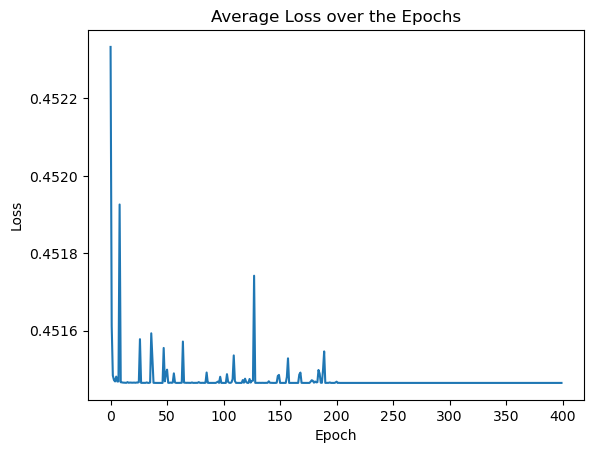

In [31]:
plt.plot(epoch_loss.values())
plt.title("Average Loss over the Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [25]:
accuracy

{1: tensor(0.3400, device='cuda:0'),
 2: tensor(0.4063, device='cuda:0'),
 3: tensor(0.3491, device='cuda:0'),
 4: tensor(0.3404, device='cuda:0'),
 5: tensor(0.3582, device='cuda:0'),
 6: tensor(0.3768, device='cuda:0'),
 7: tensor(0.3646, device='cuda:0'),
 8: tensor(0.3576, device='cuda:0'),
 9: tensor(0.3520, device='cuda:0'),
 10: tensor(0.3894, device='cuda:0'),
 11: tensor(0.3959, device='cuda:0'),
 12: tensor(0.3621, device='cuda:0'),
 13: tensor(0.3451, device='cuda:0'),
 14: tensor(0.3676, device='cuda:0'),
 15: tensor(0.3561, device='cuda:0'),
 16: tensor(0.3747, device='cuda:0'),
 17: tensor(0.3495, device='cuda:0'),
 18: tensor(0.3753, device='cuda:0'),
 19: tensor(0.3564, device='cuda:0'),
 20: tensor(0.3592, device='cuda:0'),
 21: tensor(0.3661, device='cuda:0'),
 22: tensor(0.3570, device='cuda:0'),
 23: tensor(0.3332, device='cuda:0'),
 24: tensor(0.3579, device='cuda:0'),
 25: tensor(0.3681, device='cuda:0'),
 26: tensor(0.3706, device='cuda:0'),
 27: tensor(0.3946, d

In [26]:
iou_score

{1: 3.8939420489275476e-11,
 2: 4.820909577465079e-11,
 3: 3.7654174844224733e-11,
 4: 3.4408382033879654e-11,
 5: 3.71606116033338e-11,
 6: 4.2857770457546703e-11,
 7: 4.0014130041904484e-11,
 8: 4.2973507867026416e-11,
 9: 3.5329971795355865e-11,
 10: 3.885188650673096e-11,
 11: 4.2740948575857536e-11,
 12: 3.563215413748549e-11,
 13: 3.336669248793704e-11,
 14: 3.589144768247095e-11,
 15: 3.3538115077258073e-11,
 16: 3.539019123752352e-11,
 17: 3.168090383763411e-11,
 18: 3.412409841982201e-11,
 19: 3.1520665794945385e-11,
 20: 3.240238204940802e-11,
 21: 3.2455227378525624e-11,
 22: 3.451685109316897e-11,
 23: 3.215843360153867e-11,
 24: 3.369960864692712e-11,
 25: 4.172647287280247e-11,
 26: 3.83233626266891e-11,
 27: 4.92715210184989e-11,
 28: 3.5010896460520796e-11,
 29: 3.459558170990598e-11,
 30: 4.086774516778119e-11,
 31: 3.037338069358488e-11,
 32: 3.03505513606196e-11,
 33: 3.435484958651966e-11,
 34: 3.421897888884429e-11,
 35: 3.1016511200838395e-11,
 36: 3.2109013501440

In [33]:
accuracy = {key: value.item() for key, value in accuracy.items()}
accuracy

{1: 0.3399711549282074,
 2: 0.406334787607193,
 3: 0.34910982847213745,
 4: 0.34037211537361145,
 5: 0.3582276701927185,
 6: 0.37679415941238403,
 7: 0.36456772685050964,
 8: 0.35758763551712036,
 9: 0.35204339027404785,
 10: 0.38938042521476746,
 11: 0.3959487974643707,
 12: 0.36207470297813416,
 13: 0.34512627124786377,
 14: 0.3676225244998932,
 15: 0.35605067014694214,
 16: 0.3746645450592041,
 17: 0.3494780957698822,
 18: 0.375331848859787,
 19: 0.35641902685165405,
 20: 0.3591812252998352,
 21: 0.3660983741283417,
 22: 0.35699546337127686,
 23: 0.33323127031326294,
 24: 0.35786500573158264,
 25: 0.3681162893772125,
 26: 0.37060263752937317,
 27: 0.3946274220943451,
 28: 0.34040895104408264,
 29: 0.33155927062034607,
 30: 0.355724960565567,
 31: 0.31927424669265747,
 32: 0.31724873185157776,
 33: 0.2980439066886902,
 34: 0.3217102289199829,
 35: 0.32592061161994934,
 36: 0.3390079140663147,
 37: 0.28286537528038025,
 38: 0.35200929641723633,
 39: 0.2742311954498291,
 40: 0.29447472

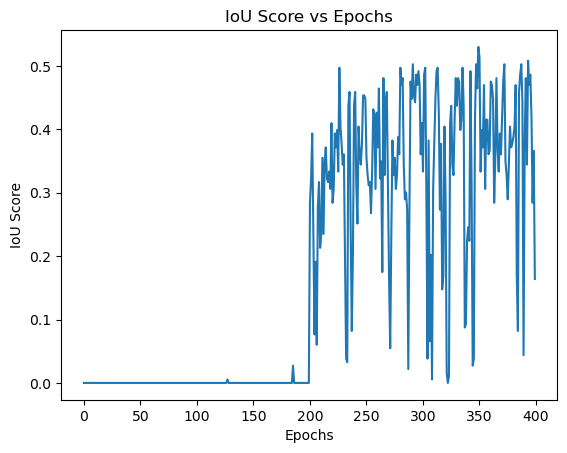

In [30]:
plt.plot(iou_score.values())
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score vs Epochs")
plt.show()

In [ ]:
dice_score = {key: value.item() for key, value in dice_score.items()}

In [50]:
df_dice = pd.DataFrame(dice_score.items(), columns=['Epoch', 'Dice Score'])
df_dice.head()

Epoch    Dice Score
0      1  2.720458e-11
1      2  3.250000e-11
2      3  2.542952e-11
3      4  2.244642e-11
4      5  2.474028e-11

Save training metric scores into a json file

In [39]:
save_scores_to_json(epoch_loss, '../rsc/train_epoch_loss.json')
save_scores_to_json(accuracy, '../rsc/train_accuracy.json')
save_scores_to_json(iou_score, '../rsc/train_iou_score.json')
save_scores_to_json(dice_score, '../rsc/train_dice_score.json')
    
print("Scores saved to JSON files!")

Scores saved to JSON files!


Load the metrics from previous training

In [ ]:
epoch_loss = load_scores_from_json('../rsc/train_epoch_loss.json')
accuracy = load_scores_from_json('../rsc/train_accuracy.json')
iou_score = load_scores_from_json('../rsc/train_iou_score.json')
dice_score = load_scores_from_json('../rsc/train_dice_score.json')

In [136]:
plot_metrics(epoch_loss, accuracy, iou_score, dice_score)

Clean up GPU memory

In [1]:
cuda.empty_cache()

# Evaluation and Training for more epochs

# For 20 epochs

## Load model from checkpoint 20

In [130]:
current_checkpoint = 20
model = load_unet_model(3, 3, current_checkpoint)

## Set test for 20 epochs

In [139]:
set_test(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [02:10<00:00,  1.05it/s]

Test finished.


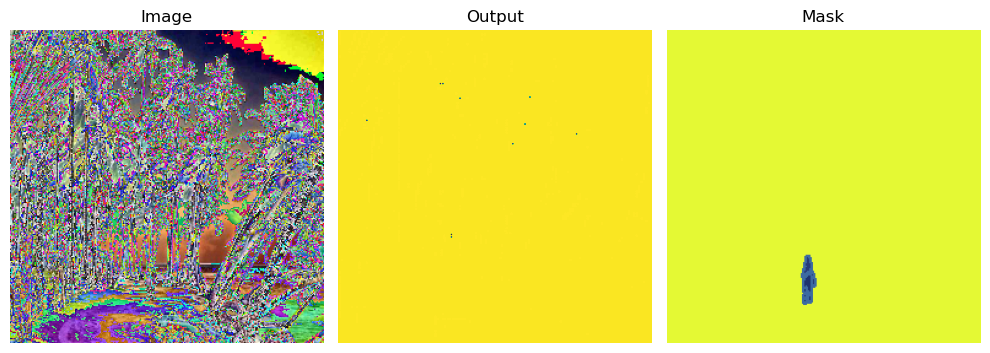

In [150]:
test_predicted_image(16, current_checkpoint)

In [176]:
iou_scores = calculate_average_iou(current_checkpoint, test_loader)

138


100%|██████████| 138/138 [00:14<00:00,  9.52it/s]


Average IoU: 0.48578548431396484


In [183]:
print(f'Max IoU score: {iou_scores[max(iou_scores, key=iou_scores.get)]}')
print(f'Avg IoU score: {sum(iou_scores.values()) / len(iou_scores)}')
print(f'Min IoU score: {iou_scores[min(iou_scores, key=iou_scores.get)]}')

Max IoU score: 0.5376453399658203
Avg IoU score: 0.48578548431396484
Min IoU score: 0.4155406951904297


In [286]:
iou_20 = {1: 0.4797077178955078,
 2: 0.49719810485839844,
 3: 0.5054779052734375,
 4: 0.4836864471435547,
 5: 0.4587211608886719,
 6: 0.5170059204101562,
 7: 0.45332908630371094,
 8: 0.5023097991943359,
 9: 0.4831275939941406,
 10: 0.4908485412597656,
 11: 0.5056419372558594,
 12: 0.5027503967285156,
 13: 0.5142917633056641,
 14: 0.48728370666503906,
 15: 0.5376453399658203,
 16: 0.5085086822509766,
 17: 0.47232818603515625,
 18: 0.5107364654541016,
 19: 0.48715972900390625,
 20: 0.5032901763916016,
 21: 0.4765033721923828,
 22: 0.48642539978027344,
 23: 0.4849262237548828,
 24: 0.4778900146484375,
 25: 0.5015850067138672,
 26: 0.5211429595947266,
 27: 0.5365085601806641,
 28: 0.48128318786621094,
 29: 0.4925251007080078,
 30: 0.45321083068847656,
 31: 0.4770488739013672,
 32: 0.48882102966308594,
 33: 0.5108470916748047,
 34: 0.4668598175048828,
 35: 0.5121784210205078,
 36: 0.49103736877441406,
 37: 0.46086883544921875,
 38: 0.5003242492675781,
 39: 0.5226840972900391,
 40: 0.43419837951660156,
 41: 0.46941375732421875,
 42: 0.5030574798583984,
 43: 0.461761474609375,
 44: 0.42952919006347656,
 45: 0.5254783630371094,
 46: 0.49345970153808594,
 47: 0.46932220458984375,
 48: 0.467071533203125,
 49: 0.470855712890625,
 50: 0.4504280090332031,
 51: 0.49939727783203125,
 52: 0.4945259094238281,
 53: 0.4984416961669922,
 54: 0.48110008239746094,
 55: 0.4626426696777344,
 56: 0.4664497375488281,
 57: 0.4702434539794922,
 58: 0.502227783203125,
 59: 0.4833030700683594,
 60: 0.5153923034667969,
 61: 0.4472484588623047,
 62: 0.510711669921875,
 63: 0.4729633331298828,
 64: 0.5034217834472656,
 65: 0.484039306640625,
 66: 0.5336399078369141,
 67: 0.47216224670410156,
 68: 0.4899578094482422,
 69: 0.4744148254394531,
 70: 0.5169944763183594,
 71: 0.5161838531494141,
 72: 0.49959754943847656,
 73: 0.49039459228515625,
 74: 0.4709129333496094,
 75: 0.46036720275878906,
 76: 0.4723625183105469,
 77: 0.4691295623779297,
 78: 0.5065994262695312,
 79: 0.5236225128173828,
 80: 0.5024280548095703,
 81: 0.4970741271972656,
 82: 0.5109024047851562,
 83: 0.4438209533691406,
 84: 0.447998046875,
 85: 0.4522743225097656,
 86: 0.4795970916748047,
 87: 0.4568958282470703,
 88: 0.4693107604980469,
 89: 0.5003166198730469,
 90: 0.4722728729248047,
 91: 0.5003223419189453,
 92: 0.49050331115722656,
 93: 0.4409294128417969,
 94: 0.5047588348388672,
 95: 0.49088478088378906,
 96: 0.4893455505371094,
 97: 0.49039649963378906,
 98: 0.47977447509765625,
 99: 0.44307899475097656,
 100: 0.4570293426513672,
 101: 0.455078125,
 102: 0.4876518249511719,
 103: 0.49330902099609375,
 104: 0.5086383819580078,
 105: 0.5219573974609375,
 106: 0.4962921142578125,
 107: 0.4651641845703125,
 108: 0.5200901031494141,
 109: 0.5255012512207031,
 110: 0.46331024169921875,
 111: 0.47920799255371094,
 112: 0.487701416015625,
 113: 0.4798393249511719,
 114: 0.5105514526367188,
 115: 0.49677467346191406,
 116: 0.48928260803222656,
 117: 0.4619941711425781,
 118: 0.4581413269042969,
 119: 0.5068607330322266,
 120: 0.509735107421875,
 121: 0.5170879364013672,
 122: 0.4690532684326172,
 123: 0.4920177459716797,
 124: 0.4749031066894531,
 125: 0.4155406951904297,
 126: 0.4807319641113281,
 127: 0.4531726837158203,
 128: 0.48723602294921875,
 129: 0.4774131774902344,
 130: 0.4651527404785156,
 131: 0.5096721649169922,
 132: 0.47255516052246094,
 133: 0.5029182434082031,
 134: 0.4740161895751953,
 135: 0.46146392822265625,
 136: 0.5080909729003906,
 137: 0.4591064453125,
 138: 0.47452545166015625}

# TODO: (by TG) make a json dump file for this...

#### IoU for 20 epochs

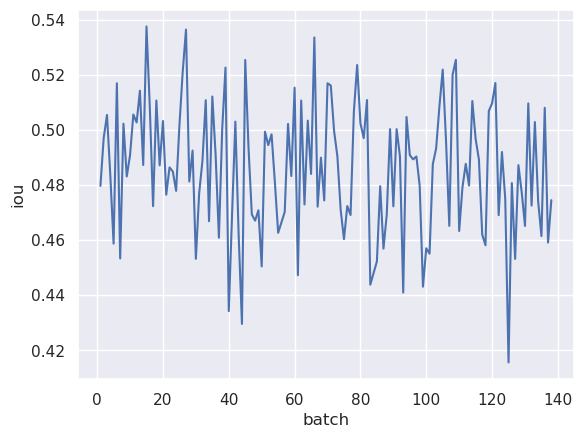

In [311]:
plt.plot(iou_20.keys(), iou_20.values(), label='iou_20')
plt.xlabel('batch')
plt.ylabel('iou')
plt.show()

# For 100 epochs

## Set training for 100 epochs (20 + 80)

In [154]:
training_loop(model, 20, 80, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 10/80: 100%|██████████| 183/183 [00:26<00:00,  6.87it/s]


Model saved: modelo_30.pth


Epoch 20/80: 100%|██████████| 183/183 [00:29<00:00,  6.17it/s]


Model saved: modelo_40.pth


Epoch 30/80: 100%|██████████| 183/183 [00:35<00:00,  5.13it/s]


Model saved: modelo_50.pth


Epoch 40/80: 100%|██████████| 183/183 [00:32<00:00,  5.71it/s]


Model saved: modelo_60.pth


Epoch 50/80: 100%|██████████| 183/183 [00:36<00:00,  5.03it/s]


Model saved: modelo_70.pth


Epoch 60/80: 100%|██████████| 183/183 [00:31<00:00,  5.73it/s]


Model saved: modelo_80.pth


Epoch 70/80: 100%|██████████| 183/183 [00:31<00:00,  5.85it/s]


Model saved: modelo_90.pth


Epoch 80/80: 100%|██████████| 183/183 [00:43<00:00,  4.22it/s]


Model saved: modelo_100.pth
Finished Training


In [171]:
current_checkpoint = 100
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [01:52<00:00,  1.22it/s]

Test finished.


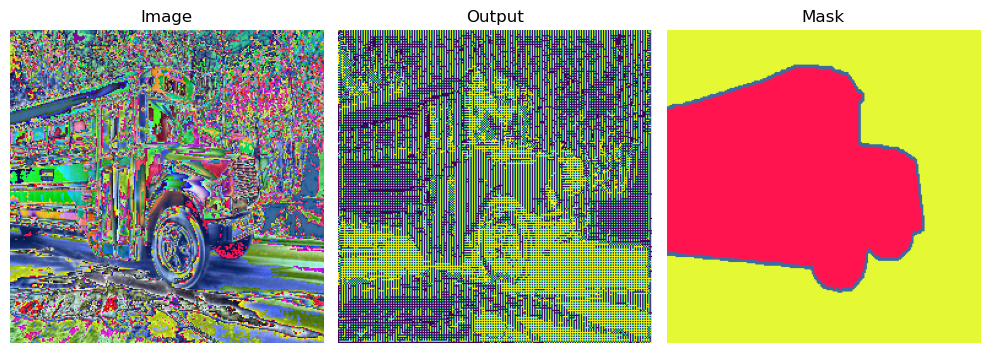

In [189]:
test_predicted_image(14, current_checkpoint)

In [ ]:
current_checkpoint = 100
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

# Training for 400 epochs (100+300)

In [191]:
training_loop(model, 100, 300, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 10/300: 100%|██████████| 183/183 [00:27<00:00,  6.69it/s]


Model saved: modelo_110.pth


Epoch 20/300: 100%|██████████| 183/183 [00:30<00:00,  6.07it/s]


Model saved: modelo_120.pth


Epoch 30/300: 100%|██████████| 183/183 [00:30<00:00,  5.92it/s]


Model saved: modelo_130.pth


Epoch 40/300: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Model saved: modelo_140.pth


Epoch 50/300: 100%|██████████| 183/183 [00:37<00:00,  4.88it/s]


Model saved: modelo_150.pth


Epoch 60/300: 100%|██████████| 183/183 [00:37<00:00,  4.89it/s]


Model saved: modelo_160.pth


Epoch 70/300: 100%|██████████| 183/183 [00:37<00:00,  4.89it/s]


Model saved: modelo_170.pth


Epoch 80/300: 100%|██████████| 183/183 [00:38<00:00,  4.71it/s]


Model saved: modelo_180.pth


Epoch 90/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_190.pth


Epoch 100/300: 100%|██████████| 183/183 [00:38<00:00,  4.76it/s]


Model saved: modelo_200.pth


Epoch 110/300: 100%|██████████| 183/183 [00:42<00:00,  4.27it/s]


Model saved: modelo_210.pth


Epoch 120/300: 100%|██████████| 183/183 [00:42<00:00,  4.28it/s]


Model saved: modelo_220.pth


Epoch 130/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_230.pth


Epoch 140/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_240.pth


Epoch 150/300: 100%|██████████| 183/183 [00:40<00:00,  4.49it/s]


Model saved: modelo_250.pth


Epoch 160/300: 100%|██████████| 183/183 [00:39<00:00,  4.69it/s]


Model saved: modelo_260.pth


Epoch 170/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_270.pth


Epoch 180/300: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s]


Model saved: modelo_280.pth


Epoch 190/300: 100%|██████████| 183/183 [00:40<00:00,  4.54it/s]


Model saved: modelo_290.pth


Epoch 200/300: 100%|██████████| 183/183 [00:37<00:00,  4.83it/s]


Model saved: modelo_300.pth


Epoch 210/300: 100%|██████████| 183/183 [00:40<00:00,  4.53it/s]


Model saved: modelo_310.pth


Epoch 220/300: 100%|██████████| 183/183 [00:37<00:00,  4.87it/s]


Model saved: modelo_320.pth


Epoch 230/300: 100%|██████████| 183/183 [00:38<00:00,  4.70it/s]


Model saved: modelo_330.pth


Epoch 240/300: 100%|██████████| 183/183 [00:40<00:00,  4.57it/s]


Model saved: modelo_340.pth


Epoch 250/300: 100%|██████████| 183/183 [00:40<00:00,  4.52it/s]


Model saved: modelo_350.pth


Epoch 260/300: 100%|██████████| 183/183 [00:40<00:00,  4.50it/s]


Model saved: modelo_360.pth


Epoch 270/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_370.pth


Epoch 280/300: 100%|██████████| 183/183 [00:41<00:00,  4.43it/s]


Model saved: modelo_380.pth


Epoch 290/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_390.pth


Epoch 300/300: 100%|██████████| 183/183 [00:40<00:00,  4.47it/s]

Model saved: modelo_400.pth
Finished Training


## For 200 epochs

In [ ]:
current_checkpoint = 200
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

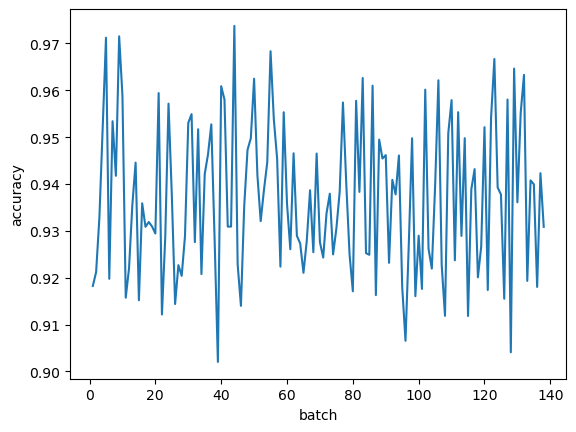

In [164]:
plt.plot(accuracies.keys(), accuracies.values(), label='accuracy')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

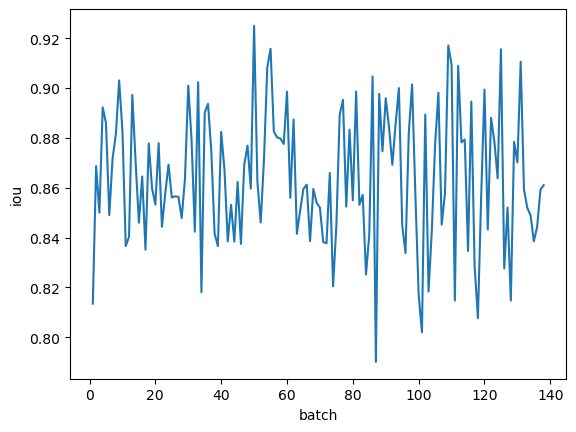

In [169]:
plt.plot(iou_scores.keys(), iou_scores.values(), label='iou')
plt.xlabel('batch')
plt.ylabel('iou')
plt.show()

In [ ]:
plt.plot(accuracies.keys(), accuracies.values(), label='accuracy', color='blue')
plt.plot(iou_scores.keys(), iou_scores.values(), label='iou', color='red')
plt.title('Accuracy x IoU')
plt.xlabel('batch')
plt.ylabel('accuracy x iou')
plt.show()

##### TODO: (**by TG**) Add accuracy and IoU scores to overall dict to plot over the epochs.

## For 300 epochs

In [328]:
current_checkpoint = 300
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using 1 GPUs.
Using 8 CPU cores.


100%|██████████| 138/138 [01:49<00:00,  1.25it/s]


Test finished.
Calculating IoU and accuracy for checkpoint 300...


100%|██████████| 138/138 [00:32<00:00,  4.31it/s]



Average IoU: 0.8205899362978728
Average Accuracy: 0.6763805150985718

Calculating F1 score for checkpoint 300...


100%|██████████| 138/138 [00:02<00:00, 54.14it/s]


Average F1 Score: 0.9999999953928763



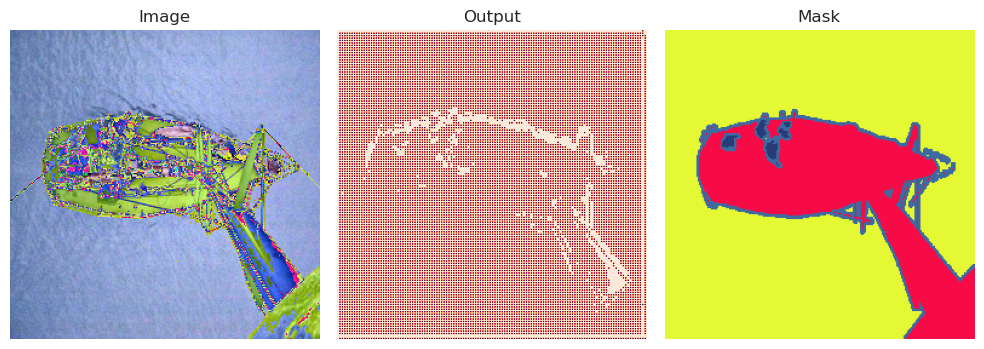

In [329]:
test_predicted_image(12, 300)

## For 400 epochs

In [361]:
current_checkpoint = 400
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using 1 GPUs.
Using 8 CPU cores.


100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Test finished.
Calculating IoU and accuracy for checkpoint 400...


100%|██████████| 138/138 [00:28<00:00,  4.88it/s]



Average IoU: 0.9999493999757628
Average Accuracy: 0.8585827350616455

Calculating F1 score for checkpoint 400...


100%|██████████| 138/138 [00:02<00:00, 60.64it/s]


Average F1 Score: 0.9999999884821908



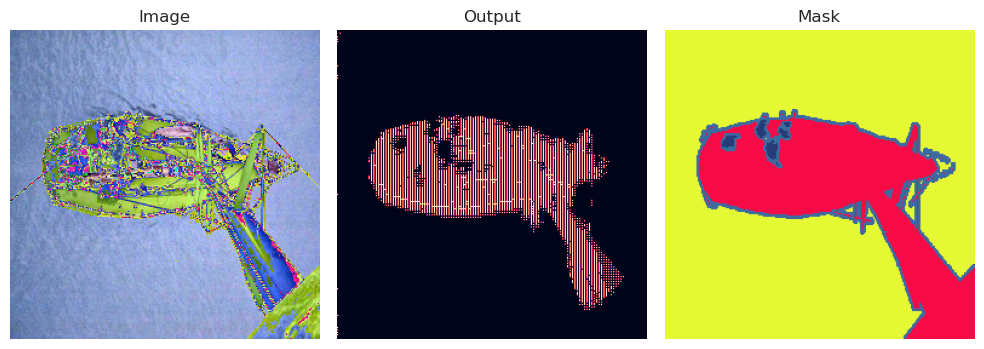

In [318]:
test_predicted_image(12, 400)

### Testing for different model checkpoints

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


Calculating progress:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating IoU and accuracy for checkpoint 100...


100%|██████████| 138/138 [00:32<00:00,  4.23it/s]



Average IoU: 0.48578548431396484
Average Accuracy: 0.2873724102973938



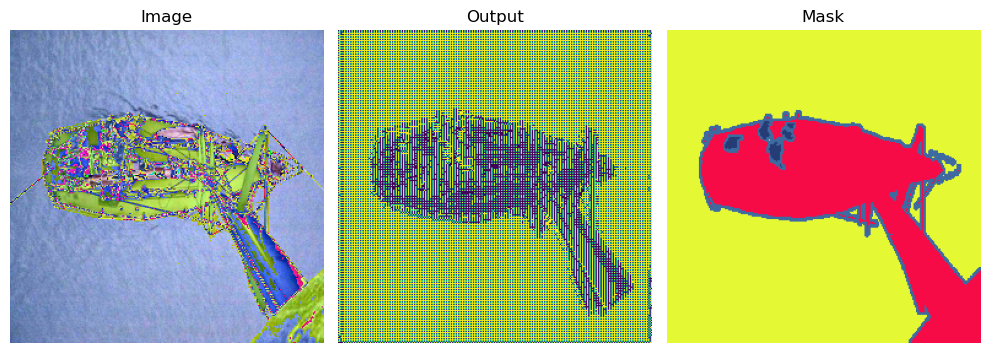

Calculating progress:  20%|██        | 1/5 [00:32<02:11, 32.99s/it]

Calculating IoU and accuracy for checkpoint 150...


100%|██████████| 138/138 [00:29<00:00,  4.63it/s]



Average IoU: 0.9715534154919611
Average Accuracy: 0.9261112213134766



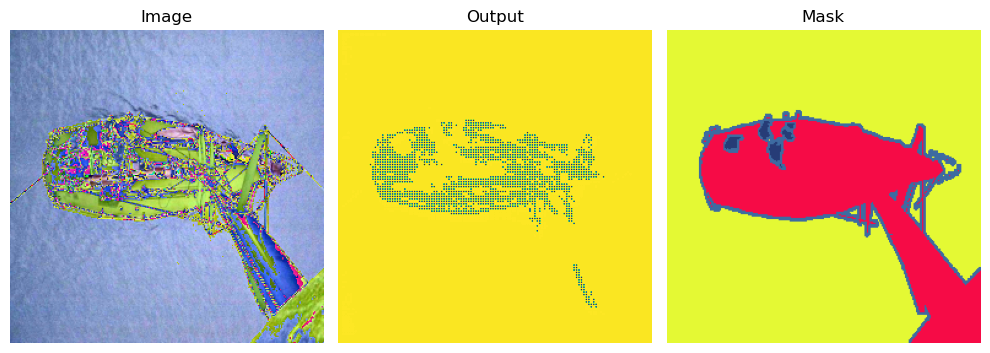

Calculating progress:  40%|████      | 2/5 [01:03<01:33, 31.31s/it]

Calculating IoU and accuracy for checkpoint 200...


  0%|          | 0/138 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../rsc/ntest200/output_1.pth'

In [143]:
checkpoints = [100, 150, 200, 300, 400]
test_loader = set_test_loader()
progress_bar = tqdm(total=len(checkpoints), desc="Calculating progress")
for checkpoint in checkpoints:
    calculate_average_metrics(checkpoint, test_loader)
    test_predicted_image(12, checkpoint)
    progress_bar.update(1)

# Rest
- `TODO`: (**by TG**) Experimental code that will be `reused/optimized/cleaned` afterwards

In [141]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

def set_test_loader(batch_length: int = 8):
    """ Set the test loader. """

    val_dir = "../data/pascal_voc_dataset/validation"
    test_dir = "../data/pascal_voc_dataset/test"

    # Transforms to input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Normalize tensor using mean and std
    def normalize_tensor(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

    # Transforms to target masks
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize_tensor,
    ])

    test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = Subset(test_set, range(1100))
    
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_length)

    return test_loader

In [142]:
import torch
from tqdm import tqdm

def test_model(model, test_loader, current_checkpoint: int):
    """ Set test data and test loader then perform the test. """

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_cpu = multiprocessing.cpu_count()
    
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        print(f"Using {num_cpu} CPU cores.")
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
    else:
        print("Using single CPU.")

    model = model.to(device)

    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images)
            
        # Save each prediction as separate files using torch.save()
        torch.save(images.cpu(), f'../rsc/test/image_{i}.pth')
        torch.save(outputs.cpu(), f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
        torch.save(masks, f'../rsc/test/mask_{i}.pth')
    
    print("Images, Outputs and masks saved!")
    
    # TODO: (by TG) modify this to return the test_loader size

In [ ]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)
    accuracy = (predicted_labels == true_labels).float().mean()
    return accuracy

def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.argmax(dim=1)
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou

def calculate_average_metrics(checkpoint: int, test_loader: DataLoader):
    
    print(f"Calculating IoU and accuracy for checkpoint {checkpoint}...")
    iou_scores = {}
    accuracy_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou

        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, masks)
        accuracy_scores[i] = accuracy

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)

    print(f"\nAverage IoU: {average_iou}")
    print(f"Average Accuracy: {average_accuracy}\n")
    
    return iou_scores, accuracy_scores


In [139]:
from tqdm import tqdm

checkpoints = [100, 150, 200, 300, 400]
soma = 0

progress_bar = tqdm(total=len(checkpoints), desc="Calculating progress")

for checkpoint in checkpoints:
    progress_bar.set_description(f"Calculating IoU and accuracy for checkpoint {checkpoint}...")
    soma += checkpoint
    # Perform your calculations here
    # Update the progress bar as needed
    progress_bar.update(1)

progress_bar.close()
print(soma)


Calculating IoU and accuracy for checkpoint 400...: 100%|██████████| 5/5 [00:00<00:00, 1530.32it/s]

1150


## Cleaning code

- `TODO`: (**by TG**) Experimental code that will be `reused/optimized/cleaned` afterwards

In [14]:
class UNet_64(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet_64, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

In [163]:
calculate_average_iou(current_checkpoint)

  0%|          | 0/182 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (8) must match the size of tensor b (3) at non-singleton dimension 1

In [127]:
masks.shape

torch.Size([8, 3, 256, 256])

In [112]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        )
        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        out = self.out(x2)
        return out.squeeze(1)  # Return segmentation map tensor


In [118]:
import multiprocessing
from torch.utils.data import DataLoader


def training_loop(model, current_checkpoint: int, num_epochs: int,
                  train_loader: DataLoader, criterion, optimizer: optim.Optimizer):
    """ Training loop. """
    

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Set the model to training mode
    model.train()

    # Define the average loss list
    average_loss = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            # Move data to the device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs = model(images)['out']
            outputs = model(images)

            # Calculate the loss
            #loss = criterion(outputs, masks.squeeze(1).long())
            loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for the given epoch
        average_loss.append(running_loss / len(train_loader))
        # saving every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
            print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
        
    print("Finished Training")

In [123]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim

# Paths
dataset_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages"
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"
mask_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/mask"

# Transforms to input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

# Download and load the PASCAL VOC dataset
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

# Split dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)


model = UNet()


# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [121]:
current_checkpoint = 0

In [122]:
training_loop(model, current_checkpoint, 20, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 1/20:   0%|          | 0/183 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([8, 1, 256, 256])) must be the same as input size (torch.Size([8, 256, 256]))

In [6]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 20

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
    #print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")

# Save the trained model

Device in use: cuda
Using 1 GPUs.


Epoch 10/20: 100%|██████████| 183/183 [00:30<00:00,  6.01it/s]


Model saved: modelo_10.pth


Epoch 20/20: 100%|██████████| 183/183 [00:32<00:00,  5.59it/s]

Model saved: modelo_20.pth


In [42]:
average_loss

[0.37319588164488476,
 0.3719679596808439,
 0.3691500632163605,
 0.36747703119053865,
 0.3666572610700065,
 0.3647408145047276,
 0.36373205466674324,
 0.3638461534279943,
 0.36240784921607033,
 0.3604973939761438,
 0.3604383679524146,
 0.35917985081021253,
 0.3602402689841276,
 0.35747125557537285,
 0.3576149700280747,
 0.35627455528968016,
 0.3577086350631193,
 0.3567337242306256,
 0.3556958868529627,
 0.35377030571301776]

In [58]:
avg_loss = [0.37319588164488476,
 0.3719679596808439,
 0.3691500632163605,
 0.36747703119053865,
 0.3666572610700065,
 0.3647408145047276,
 0.36373205466674324,
 0.3638461534279943,
 0.36240784921607033,
 0.3604973939761438,
 0.3604383679524146,
 0.35917985081021253,
 0.3602402689841276,
 0.35747125557537285,
 0.3576149700280747,
 0.35627455528968016,
 0.3577086350631193,
 0.3567337242306256,
 0.3556958868529627,
 0.35377030571301776]

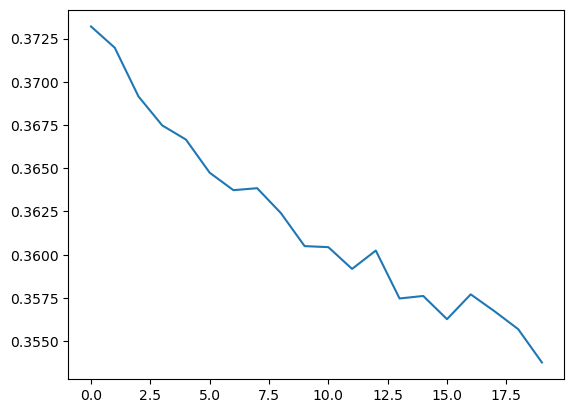

In [44]:
# plot average loss over the epochs
plt.plot(average_loss)
plt.show()

## Setting test loader

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [9]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [12]:
for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest20/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

100%|██████████| 138/138 [00:14<00:00,  9.32it/s]


In [37]:
index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]))

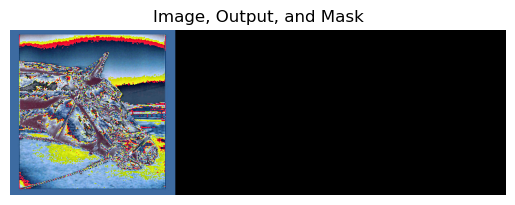

In [50]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0).unsqueeze(0).to(torch.float32)  # Add batch dimension
mask_single = mask[0]

# Convert the single image and mask tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())

# Convert the output and mask tensors to PIL images and convert to RGB format
output_pil = transforms.ToPILImage()(output_single.cpu().squeeze().to(torch.uint8)).convert('RGB')
mask_pil = transforms.ToPILImage()(mask_single.cpu().squeeze().to(torch.uint8)).convert('RGB')

# Convert the PIL images to NumPy arrays
image_np = np.array(image_pil)
output_np = np.array(output_pil)
mask_np = np.array(mask_pil)

# Create a grid of images
grid = np.concatenate([image_np, output_np, mask_np], axis=1)

# Plot the grid
plt.imshow(grid)
plt.title('Image, Output, and Mask')
plt.axis('off')
plt.show()


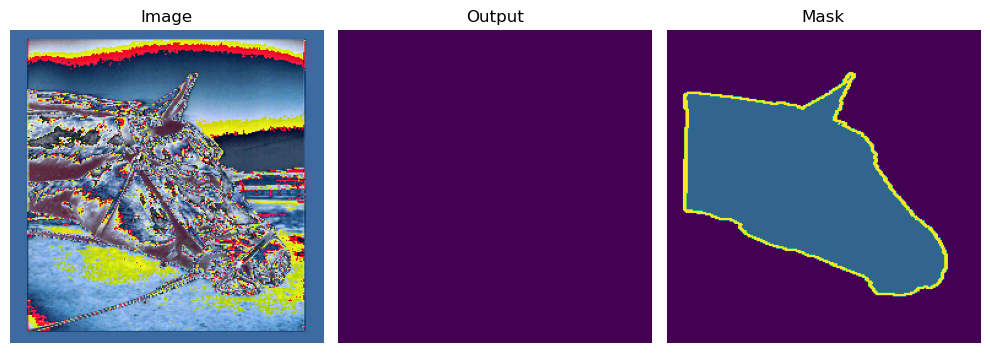

In [55]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Training for over 20 epochs

In [56]:
current_checkpoint = 20

In [57]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 20

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 20

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/20: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]


Model saved: modelo_30.pth


Epoch 20/20: 100%|██████████| 183/183 [00:32<00:00,  5.67it/s]

Model saved: modelo_40.pth


In [59]:
average_loss

[0.35641822284036645,
 0.3540027541378157,
 0.3545653425116357,
 0.35225114592763246,
 0.35283141505848514,
 0.35329381844710783,
 0.35136777960537563,
 0.35178856396935676,
 0.35295154032160025,
 0.35125196411635706,
 0.35188570203351194,
 0.35181714040659817,
 0.3514474149121613,
 0.3492979939843788,
 0.349271175721304,
 0.3507007383257965,
 0.3502523898264098,
 0.3508897014980108,
 0.35020682630968875,
 0.348823435726713]

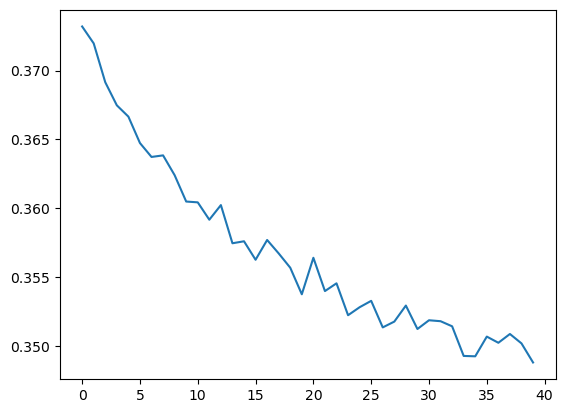

In [64]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [67]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest40/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


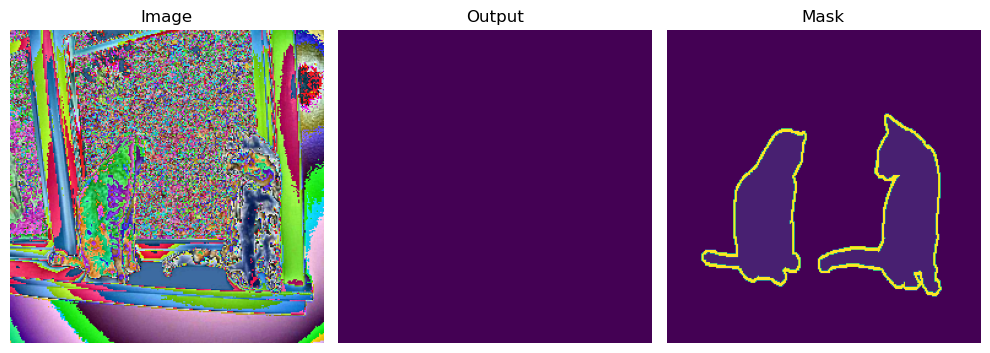

In [69]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Training for over 40 epochs

In [70]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 40

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 60

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/60: 100%|██████████| 183/183 [00:33<00:00,  5.44it/s]


Model saved: modelo_50.pth


Epoch 20/60: 100%|██████████| 183/183 [00:36<00:00,  4.97it/s]


Model saved: modelo_60.pth


Epoch 30/60: 100%|██████████| 183/183 [00:38<00:00,  4.73it/s]


Model saved: modelo_70.pth


Epoch 40/60: 100%|██████████| 183/183 [00:37<00:00,  4.84it/s]


Model saved: modelo_80.pth


Epoch 50/60: 100%|██████████| 183/183 [00:36<00:00,  4.96it/s]


Model saved: modelo_90.pth


Epoch 60/60: 100%|██████████| 183/183 [00:42<00:00,  4.34it/s]

Model saved: modelo_100.pth


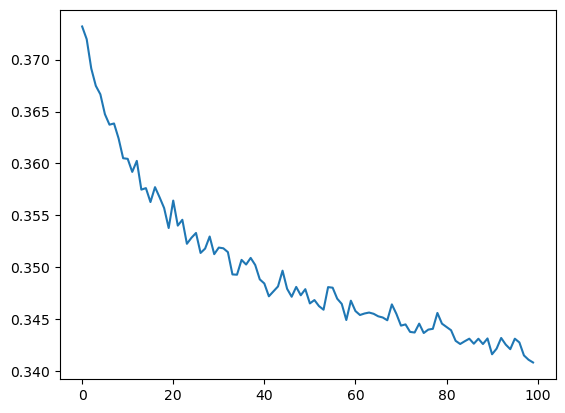

In [71]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [72]:
current_checkpoint = 100

In [73]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [00:22<00:00,  6.26it/s]


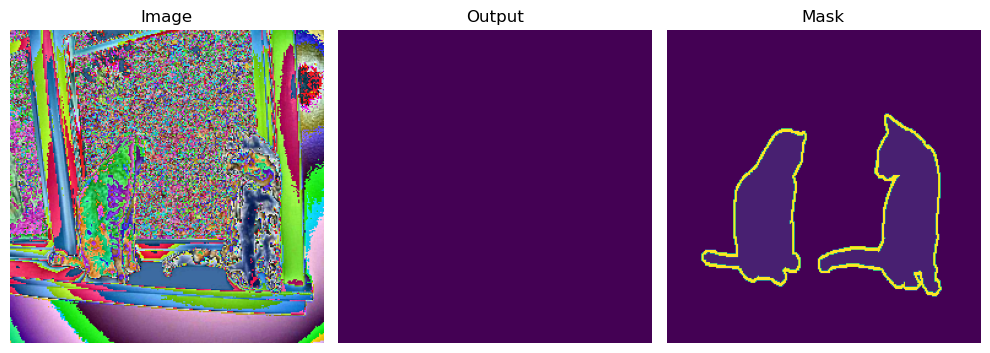

In [75]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [82]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

def set_test(current_checkpoint: int):
    """ Set test data and test loader then perform the test. """

    val_dir = "../data/pascal_voc_dataset/validation"
    test_dir = "../data/pascal_voc_dataset/test"

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),  # Convert to single-channel grayscale
        transforms.ToTensor(),
    ])

    test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = Subset(test_set, range(1100))

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        with torch.no_grad():
            outputs = model(images)
        
        # Save each prediction as separate files using torch.save()
        torch.save(images, f'../rsc/test/image_{i}.pth')
        torch.save(outputs, f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
        torch.save(masks, f'../rsc/test/mask_{i}.pth')
        
    print("Test finished.")

## Training for over 100 epochs

In [76]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 100

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 100

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/100: 100%|██████████| 183/183 [00:36<00:00,  5.05it/s]


Model saved: modelo_110.pth


Epoch 20/100: 100%|██████████| 183/183 [00:37<00:00,  4.83it/s]


Model saved: modelo_120.pth


Epoch 30/100: 100%|██████████| 183/183 [00:41<00:00,  4.42it/s]


Model saved: modelo_130.pth


Epoch 40/100: 100%|██████████| 183/183 [00:41<00:00,  4.43it/s]


Model saved: modelo_140.pth


Epoch 50/100: 100%|██████████| 183/183 [00:41<00:00,  4.39it/s]


Model saved: modelo_150.pth


Epoch 60/100: 100%|██████████| 183/183 [00:43<00:00,  4.22it/s]


Model saved: modelo_160.pth


Epoch 70/100: 100%|██████████| 183/183 [00:39<00:00,  4.66it/s]


Model saved: modelo_170.pth


Epoch 80/100: 100%|██████████| 183/183 [00:39<00:00,  4.64it/s]


Model saved: modelo_180.pth


Epoch 90/100: 100%|██████████| 183/183 [00:37<00:00,  4.87it/s]


Model saved: modelo_190.pth


Epoch 100/100: 100%|██████████| 183/183 [00:40<00:00,  4.51it/s]


Model saved: modelo_200.pth


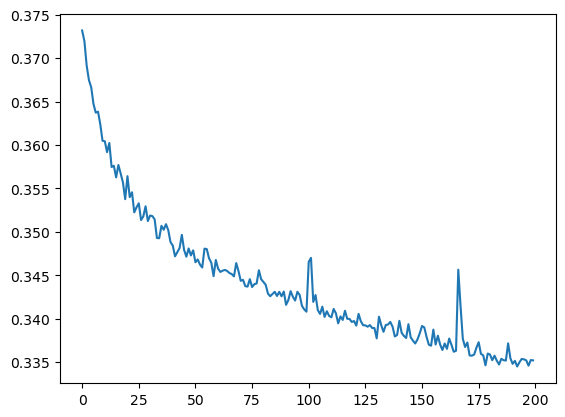

In [77]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [101]:
def update_average_loss(avg_loss, average_loss):
    avg_loss.extend(average_loss)
    plt.plot(avg_loss)
    return avg_loss

In [83]:
set_test(current_checkpoint=200)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [00:24<00:00,  5.71it/s]

Test finished.


In [97]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def test_predicted_image(index: int, checkpoint: int):
    """ Display the image, ground truth mask, and predicted mask. """
    
    image = torch.load(f'../rsc/test/image_{index}.pth')
    output = torch.load(f'../rsc/ntest200/output_{index}.pth')
    mask = torch.load(f'../rsc/test/mask_{index}.pth')

    image.shape, output.shape, mask.shape

    # Select a specific image from the batch (e.g., the first image)
    image_single = image[0]
    output_single = output[0].argmax(dim=0, keepdim=True)
    mask_single = mask[0]

    # Scale the output and mask tensors to the range [0, 255]
    output_single_scaled = (output_single * 255).to(torch.uint8)
    mask_single_scaled = (mask_single * 255).to(torch.uint8)

    # Convert the single image and scaled tensors to PIL images
    image_pil = transforms.ToPILImage()(image_single.cpu())
    output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
    mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot the images in the subplots
    axes[0].imshow(image_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(output_pil)
    axes[1].set_title('Output')
    axes[1].axis('off')

    axes[2].imshow(mask_pil)
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

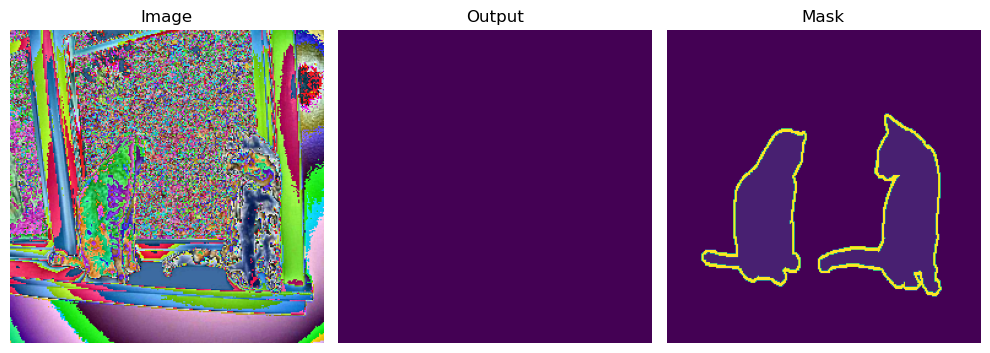

In [104]:
test_predicted_image(38, 200)

In [95]:
import torch
from tqdm import tqdm

def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    # Move tensors to the same device
    device = outputs.device
    masks = masks.to(device)
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou


def calculate_average_iou(checkpoint: int):
    iou_scores = {}
    for i in tqdm(range(1, len(test_loader)+1)):
        
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou

    print("\nAverage IoU:", sum(iou_scores.values()) / len(iou_scores))

In [96]:
calculate_average_iou(200)

100%|██████████| 138/138 [00:00<00:00, 358.95it/s]


Average IoU: 0.0


In [110]:
import multiprocessing
from torch.utils.data import DataLoader


def training_loop(model, current_checkpoint: int, num_epochs: int):
    """ Training loop. """
    #model = deeplabv3_resnet50(weight=True)

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Define the loss function
    #criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set the model to training mode
    model.train()

    # Define the data loader
    #train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

    #train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    #val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
    #test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    # Define the number of epochs
    #num_epochs = 100

    # Define the average loss list
    average_loss = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            # Move data to the device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs = model(images)['out']
            outputs = model(images)

            # Calculate the loss
            #loss = criterion(outputs, masks.squeeze(1).long())
            loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for the given epoch
        average_loss.append(running_loss / len(train_loader))
        # saving every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
            print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

In [ ]:
training_loop(model, 200, 100)